
# General Index Data Pipeline Framework

---
Created 6/3/22 by Ian Hay   
Updated 8/9/22

### Background: Data Pipeline

---
When we consider the General Index in its total scope, the sheer size of the data is enticing for training large language models (LLMs). These models can be incredibly powerful; for example, [GPT-3](https://en.wikipedia.org/wiki/GPT-3) capable of summarizing long-form essays, or Google Translate. In the case of the General Index, we are also specifically limited to using previously extracted n-grams from the original manuscripts. What this means is the General Index cannot be trained (on its own) to summarize whole manuscripts, for instance. However, it can be used for applications like topic extracting. Being constrained to n-grams may prove beneficial, as models trained on this data use as little information as possible from the underlying manuscript. In fact, doing so could provide a plug-and-play model that can be easily adopted to other datasets of n-grams. The General Index is thus a great framework itself for topic extraction models that may want to add supplemental sources to their training data.   

This brings us back to the underlying data. To train a model, we must convert the natural language data to a more machine readable format. We already handled preprocessing of the data, but what about the actual processing? To do this, the first step is to "embed" the language data into numerical vectors. These vectors represent an n-dimensional value for each word that aim to encode the semantics of the word within the underlying dataset. Embedding can also generalize whole manuscipts or documents into document embeddings, or n-grams into n-gram embeddings. The specific embedding technique can vary and is essential to the success of the models trained on it. Embeddings can come from pre-trained models like BERT, or can be trained on the underlying data via unsupervised neural networks. In the end, regardless of the specific embedding transformer, we will have a set of numerical vectors for each manuscript.  

From these vectors, we can build a matrix by stacking vectors as rows on top of eachother. Each row represents a unique word or document, depending on the embedding, and each column a dimension of the vector embedding. This matrix can easily be fed into all kinds of models. A common model to run early is some form of dimensional reduction to reduce the complexity of the vector space. This can improve both the speed and performance of downstream models, and they also can be used to visualize high-dimensional data using graphs. In this application, UMAP, or Uniform Manifold Approximation and Projection, is used to reduce the embedding's dimension; it was chosen because it does a particularly good job with high dimensional data and should scale up well with larger slices of the General Index.

The matrix of vector embeddings, now in a less complex form, can then be clustered using all kinds of machine learning algorithms. These clusters represent similar manuscripts, and keywords can be extracted from the n-grams to determine to overall topic. This Notebook makes use of HDBSCAN, or Hierarchical Density-Based Spatial Clustering for Applications with Noise. HDBSCAN is nice as it provides a hierarchy of clusters and can provide topics and sub-topics for a particular manuscript, offering more granularity for millions of manuscripts across an untold numbers of subjects. 

Clusters can be compared to one another by how similar their manuscripts' embeddings are. Similarity, in this case, is defined using cosine similarity, which calculates cosine of the angle between any 2 n-dimensional vectors:

[Cosine Similarity](https://en.wikipedia.org/wiki/Cosine_similarity) ($S_C$) of vectors $A$ and $B: S_C(A,B) \vcentcolon= \cos(\theta) = \frac{A \cdot B}{|A||B|}$

Topics can be extracted by comparing how similar clusters are to one another. For instance, the clusters *microbiology* and *bioinformatics* may be combined under a larger *biology* topic. This is done using TF-IDF: Term-Frequency Inverse-Document-Frequency. This is a common method for extracting the most relevant terms from an underlying corpus of data. The TF-IDF data is calculated for terms within each cluster extracted using HDBSCAN. The clusters can be combined by measuring the cosine similarity between clusters and merging the most similar ones together.

In totality, manuscripts input to the model can be assigned a topic, subtopics, and keywords associated with their n-grams by determining how similar they are to tems of millions of research papers. The full data pipeline can be seen below.

![data pipeline]("data_pipeline.png")

From here, the similarity between topics, between subtopics within a topic, and between manuscripts within a subtopic can be used to construct a tree graph connecting the similarity of everything to one another. This network can be traversed to determine the similarities and crosslinks between a large subset of human knowledge. It will hopefully provide insight into what humanity has studied and what may be hidden right in front of us.

This data pipeline was influenced rather heavily by Maarten Grootendorst who authored [the paper on BERTopic](https://arxiv.org/pdf/2203.05794.pdf), a model for topic extraction using BERT embeddings. He has posted [several Medium articles](https://towardsdatascience.com/topic-modeling-with-bert-779f7db187e6) detailing working with BERT for topic modeling. It was also aided by Vibhu Jawa and Mayank Anand, who authored a Medium article on topic modeling with BERT transformers. [You can read the full article here](https://medium.com/rapids-ai/accelerating-topic-modeling-with-rapids-and-bert-models-be9909eeed2) and the work they do to compare CPU versus GPU processing capabilities, something the General Index models will no doubt need to accomplish in the near future.

### Imports
Dependencies

---
[Python 3.8+](https://www.python.org/downloads/release/python-380/)    
[Pandas](https://pandas.pydata.org/)   
[NumPy](https://numpy.org/)    
[NetworkX](https://networkx.org/)  
[pyvis](https://pyvis.readthedocs.io/en/latest/install.html)   
[scikit-learn](https://scikit-learn.org/stable/index.html)  
[seaborn](https://seaborn.pydata.org/)  
[nltk](https://www.nltk.org/)   
[gensim](https://pypi.org/project/gensim/)  
[spacy](https://pypi.org/project/spacy/)    

In [1]:
from time import time
import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import re
import nltk
import ssl
import gensim
import spacy
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from collections import Counter
from pyvis import network as net
from pyvis.network import Network
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler

In [2]:
"""
Run this line in your python environment before running the code below: 

python -m spacy download en_core_web_sm

"""
try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ianha\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Functions
---
This section defines the functions used to process and utilize the data.

In [3]:
# Data Processing -------------------------------------------------------------------------------------------

def getDocColumn(df, column, newColumnName):
    """
    Given a dataframe and a column of datatype list, constructs
    a new column newColumnName with the list joined into a single
    string and items separated by spaces (" ").
    """
    strDict = {}
    for row in range(len(df)):
        text = ". ".join(df.iloc[row][column])
        text = text + "."
        strDict[df.index[row]] = text
    dfStr = pd.Series(strDict, name=newColumnName)
    df[newColumnName] = dfStr

def getBagOfWordsDF(df, docColumn):
    """
    """
    countvec = CountVectorizer()
    X = countvec.fit_transform(df[docColumn])
    dfBOW = pd.DataFrame(X.toarray(),columns=countvec.get_feature_names_out())
    dfBOW.set_index(df.index, inplace=True)
    return dfBOW

def getNounsAndVerbs(df, column, newColumnName):
    """
    Utilizes Spacy to extract nouns and verbs from ngrams
    and build a new column with only these terms.
    """
    nounAndVerbDict = {}
    for row in range(len(df)):
        text = ". ".join(df.iloc[row][column])
        doc = nlp(text)
        nounList = [chunk.text for chunk in doc.noun_chunks]
        verbList = [token.lemma_ for token in doc if token.pos_ == "VERB"]
        nounAndVerbDict[df.index[row]] = nounList + verbList
    dfNounAndVerb = pd.Series(nounAndVerbDict, name=newColumnName)
    df[newColumnName] = dfNounAndVerb

def partOfSpeechTagging(texts, POS=["NOUN", "ADJ", "ADV", "VERB"]):
    """
    https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/#16buildingldamalletmodel
    """
    textTagged = []
    for text in texts:
        doc = nlp(text)
        text_ = [token.lemma_ for token in doc if token.pos_ in POS]
        textTagged.append(" ".join(text_))
    return textTagged

def removeStopWords(texts):
    """
    Takes in texts (words in a single string separated by spaces).
    https://stackoverflow.com/questions/29523254/python-remove-stop-words-from-pandas-dataframe
    """
    textParsed = []
    from nltk.corpus import stopwords
    _stopWords = stopwords.words("english")
    _stopWords.extend(["-pron-", "pron"]) # these words appears in many ngrams without apparent meaning
    textParsed = texts.apply(lambda x: " ".join([word for word in x.split() if word not in (list(_stopWords))]))
    return textParsed

def getUniqueWordsColumn(df, column, newColumnName, nonWords=[]):
    """
    Given a dataframe and column, constructs a new column with name newColumnName
    of the unique words in  df[column].
    The object in  df[column]  must be a list of strings.
    Returns the updated dataframe.
    """

    ### deprecated ###

    df[newColumnName] = df[column]
    for row in range(len(df[newColumnName])):
        df[newColumnName][row] = df[column].iloc[row]
        string_list = []
        for string in df[newColumnName].iloc[row]:
            string_list.append(string.split(" ")) # splits words into list of individual word strings
        string_list = list(itertools.chain(*string_list)) # concatenates nested list into 1D list
        string_list = list(set(string_list)) # grabs only unique string items
        for nonword in nonWords:
            if nonword in string_list:
                string_list.remove(nonword)
        df.loc[newColumnName].iloc[row] = string_list
    return df

def buildAdjacencyMatrixByColumn(df, column):
    """
    Given a dataframe and a column, constructs an adjacency matrix
    of size [n x n] where  n  is the number of rows of the dataframe.
    The adjacency matrix edge weights represent the number of similar elements.
    The datatype in  df[column]  must be a list.
    """
    n = len(df[column])
    adjMatrix = np.zeros((n, n))
    for n1 in range(n):
        ngram1 = df[column].iloc[n1]
        for n2 in range(n):
            ngram2 = df[column].iloc[n2]
            numSimilar = numSimilarStrings(ngram1, ngram2)
            if n1 != n2 & numSimilar > 0: # removes recursive edges
                adjMatrix[n1][n2] = numSimilar 
    return adjMatrix

def buildAdjacencyListByColumn(df, column):
    """
    Given a dataframe and a column, constructs an adjacency list
    as a nestd dictionary with  n  keys in the outermost dict, where
    n  is the number of rows in the dataframe.
    The adjacency list edge weights represent the number of similar elements.
    The datatype in  df[column]  must be a list.
    """
    n = len(df[column])

    adjDict = {} # consider using the hash to represent nodes instead of numbers
    for n1 in range(n):

        nodeDict = {}
        ngram1 = df[column].iloc[n1]
        for n2 in range(n):
            ngram2 = df[column].iloc[n2]
            numSimilar = numSimilarStrings(ngram1, ngram2)
            if n1 != n2 & numSimilar > 0: # removes recursive edges
                nodeDict[n2] = {"weight" : numSimilar} # https://networkx.org/documentation/stable/reference/generated/networkx.convert.from_dict_of_dicts.html
        adjDict[n1] = nodeDict

    return adjDict

def buildAdjacencyMatrixByCoOccurence(dfBOW):
    """
    """
    X = np.array(dfBOW.values)
    coocc = np.dot(X.T, X)
    np.fill_diagonal(coocc, 0)
    return coocc

def buildDocVectorMatrixByColumn(df, docColumn, vectorSize=50, minCount=2, iterations=100, maxLen=30):
    """
    Given a dataframe and a column storing documents,
    trains a gensim doc2vec model and outputs
    the vector matrix.
    """
    def read_corpus(documents):
        for i, plot in enumerate(documents):
            yield gensim.models.doc2vec.TaggedDocument(gensim.utils.simple_preprocess(plot, max_len=maxLen), [i])

    train_corpus = list(read_corpus(df[docColumn]))
    model = gensim.models.doc2vec.Doc2Vec(vector_size=vectorSize, min_count=minCount, epochs=iterations) # hyperparameters
    model.build_vocab(train_corpus)
    model.train(train_corpus, total_examples=model.corpus_count, epochs=model.epochs)
    docVectors = model.dv.vectors
    return docVectors

def buildAdjacencyMatrixByCosineSimilarity(vecMatrix):
    """
    Given a vector matrix, computes the cosine similarity score
    between rows of the matrix and stores the values in an
    adjacency matrix.
    """
    n = len(vecMatrix)
    cosSimMatrix = np.zeros((n,n))
    for row in range(n):
        a = vecMatrix[row]
        for otherRow in range(n):
            b = vecMatrix[otherRow]
            cosSimMatrix[row][otherRow] = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
    np.fill_diagonal(cosSimMatrix, 0)
    return cosSimMatrix

In [4]:
# Utility --------------------------------------------------------------------------------------------------

def loadTextFileIntoDataframe(filepath, columns, splittingChar="\t"):
    """
    Opens the given filepath into a pandas dataframe.
    Splits the list by the denoted character, by default tab.
    Returns a pandas dataframe.
    """
    with open(filepath) as file:
        data = file.readlines()
    df = pd.DataFrame(columns=columns)
    for line in data:
        lineSplit = [line.split(splittingChar)]
        if len(lineSplit[0]) < len(columns):
            for x in range(len(columns) - len(lineSplit[0])):
                lineSplit[0].append("0")
        lineDF = pd.DataFrame(lineSplit, columns=columns)
        df = pd.concat([df, lineDF], axis=0, ignore_index=True)
    return df

def numSimilarStrings(stringList1, stringList2):
    """
    Given two lists of strings, returns the number of strings they both share.
    In other words, the size of the subset intersection of stringList1 and stringList2.
    """

    # is there a faster way to do this with sets?

    count = 0
    for string in stringList1:
        if string in stringList2:
            count = count + 1
    return count

def subtractListsOfInts(_list1, _list2):
    """
    Given two lists of items, returns a list of items
    in _list1 and not in _list2.
    Utilizes collections.Counter
    Returns a list of items.

    https://stackoverflow.com/questions/2070643/subtracting-two-lists-in-python
    """
    _set1 = Counter(_list1)
    _set2 = Counter(_list2)
    _set1_2 = _set1 - _set2
    return list(_set1_2.elements())

def cosineSimilarityNumMostSimilar(model, word, target_list, num):
    """
    https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92
    """
    cosine_dict ={}
    word_list = []
    a = model[word]
    for item in target_list :
        if item != word :
            b = model [item]
            cos_sim = np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))
            cosine_dict[item] = cos_sim
    dist_sort=sorted(cosine_dict.items(), key=lambda dist: dist[1],reverse = True) ## in descending order 
    for item in dist_sort:
        word_list.append((item[0],  item[1]))
    return word_list[0:num]

def standardizeDataColumn(df, column, newColumnName):
    """
    Standardizes the column of the dataframe df.
    Adds the new column newColumnName to the dataframe inplace.
    Utilizes SKLearn.preprocessing.standardscaler.
    Mean is 0, variance is 1
    """
    scaler = StandardScaler()
    scaledSeries = pd.Series(np.reshape(scaler.fit_transform(np.array(df[column]).reshape(-1, 1)), (-1)), name=newColumnName, index=df.index)
    scaledSeries = scaledSeries + 1 # adding 1 scales most (~98%) to be in range [0, 2] for graphing purposes
    df[newColumnName] = scaledSeries


In [5]:
# Visualization -------------------------------------------------------------------------------------------

def visualizeNetworkHTML(_graph, _filename, _width="1920px", _height="1080px", _physics=False):
    """
    Given a NetworkX graph and the filename to save to, builds an HTML
    graph of that network. Optional parameters are width and height of graph.
    Uses pyvis to build an interactive HTML graph of a NetworkX graph.
    Uses NetworkX for graph storage.
    """
    _net = Network(width=_width, height=_height, notebook=True)
    _net.toggle_physics(_physics)
    _net.barnes_hut()
    _net.from_nx(_graph)
    _net.show(_filename)

def plot_top_words_one_topic(model, feature_names, n_top_words, title):
    """
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    """
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]
        plt.barh(top_features, weights, height=0.7)
        plt.tick_params(axis="both", which="major", labelsize=12)
        plt.suptitle(title, fontsize=25)
    plt.show()

def plot_top_words(model, feature_names, n_top_words, title, n_topics):
    """
    https://scikit-learn.org/stable/auto_examples/applications/plot_topics_extraction_with_nmf_lda.html#sphx-glr-auto-examples-applications-plot-topics-extraction-with-nmf-lda-py
    """
    fig, axes = plt.subplots(1, n_topics, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 20})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=25)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

def drawNetworkgraph(networkx_graph,notebook=True,output_filename='graph.html',show_buttons=True,only_physics_buttons=False,
                height=None,width=None,bgcolor=None,font_color=None,pyvis_options=None):
    """
    https://gist.github.com/maciejkos/e3bc958aac9e7a245dddff8d86058e17
    
    This function accepts a networkx graph object,
    converts it to a pyvis network object preserving its node and edge attributes,
    and both returns and saves a dynamic network visualization.
    Valid node attributes include:
        "size", "value", "title", "x", "y", "label", "color".
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_node)
    Valid edge attributes include:
        "arrowStrikethrough", "hidden", "physics", "title", "value", "width"
        (For more info: https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.network.Network.add_edge)
    Args:
        networkx_graph: The graph to convert and display
        notebook: Display in Jupyter?
        output_filename: Where to save the converted network
        show_buttons: Show buttons in saved version of network?
        only_physics_buttons: Show only buttons controlling physics of network?
        height: height in px or %, e.g, "750px" or "100%
        width: width in px or %, e.g, "750px" or "100%
        bgcolor: background color, e.g., "black" or "#222222"
        font_color: font color,  e.g., "black" or "#222222"
        pyvis_options: provide pyvis-specific options (https://pyvis.readthedocs.io/en/latest/documentation.html#pyvis.options.Options.set)
    """

    # make a pyvis network
    network_class_parameters = {"notebook": notebook, "height": height, "width": width, "bgcolor": bgcolor, "font_color": font_color}
    pyvis_graph = net.Network(**{parameter_name: parameter_value for parameter_name, parameter_value in network_class_parameters.items() if parameter_value})

    # for each node and its attributes in the networkx graph
    for node,node_attrs in networkx_graph.nodes(data=True):
        pyvis_graph.add_node(node,**node_attrs)

    # for each edge and its attributes in the networkx graph
    for source,target,edge_attrs in networkx_graph.edges(data=True):
        # if value/width not specified directly, and weight is specified, set 'value' to 'weight'
        if not 'value' in edge_attrs and not 'width' in edge_attrs and 'weight' in edge_attrs:
            # place at key 'value' the weight of the edge
            edge_attrs['value']=edge_attrs['weight']
        # add the edge
        pyvis_graph.add_edge(source,target,**edge_attrs)

    # turn buttons on
    if show_buttons:
        if only_physics_buttons:
            pyvis_graph.show_buttons(filter_=['physics'])
        else:
            pyvis_graph.show_buttons()

    # pyvis-specific options
    if pyvis_options:
        pyvis_graph.set_options(pyvis_options)

    # return and also save
    return pyvis_graph.show(output_filename)

def display_closestwords_tsnescatterplot(model, word, size):
    """
    https://towardsdatascience.com/a-beginners-guide-to-word-embedding-with-gensim-word2vec-model-5970fa56cc92
    """
    arr = np.empty((0,size), dtype='f')
    word_labels = [word]
    close_words = model.similar_by_word(word)
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
            
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    plt.scatter(x_coords, y_coords)
    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points')
        plt.xlim(x_coords.min()+0.00005, x_coords.max()+0.00005)
        plt.ylim(y_coords.min()+0.00005, y_coords.max()+0.00005)
        plt.show()


### Building Dataframe and Processing Data
---

*Same as in `1. what is the general index`.*

This section inputs the raw data into a Pandas Dataframe and preprocesses it to make the data more 
machine readable. It utilizes the Spacy to extract only the nouns, adjectives, verbs, and adverbs
from the ngrams, and NLTK to remove stopwords. It then groups the data by manuscript using the *hash* column.

Importing the data is the first step of any project. To make working with the data as easy as possible, its stored here in a Pandas Dataframe. For those unfamiliar with Pandas, a Dataframe is a two-dimensional object that stores the data  with each feature stored as a column, and indexes stored as rows. The columns can be labeled for increased readability, and the index can be set to a particular column. In this case, the data is indexed by each manuscript's hash to make it easy to identify the underlying manuscript simply by findings its row.  

With the raw General Index data, the next step is to preprocess the data. The reason preprocessing is important is to aid the readability of the data. Words like "the", "an", or "for" don't tell us much about the topic of the manuscript and can cause algorithms to misinterpret the similarity of manuscripts. Particularly for ngrams, where there are only a handful of words, removing these [*stopwords*](https://medium.com/analytics-vidhya/nlp-essentials-removing-stopwords-and-performing-text-normalization-using-nltk-and-spacy-in-python-2c4024d2e343) as they are called can dramatically boost machine effectiveness and performance. Additionally, words like "antediluvian" and "antediluvians" can semantically refer to the same topic but, as different words, may be misinterpretted by algorithms as completely different. For this, we can utilize text normalization through stemming and lemmatization where words are brought back to their root which, in this case, would be "antediluvian".

It's important to note that these preprocessing techniques are not essential or even helpful for every usecase. Some NLP models are particularly good at picking apart context and require these words to understand the order each word appears in a sentence to determine the exact semantics. Thus, it is important to retain the raw, unprocessed data and compare model performance using the unprocessed and preprocessed data to determine what works best for a particular application. In this application, we seek to understand the similarity and extract topics among a broad corpus, and preprocessing techniques will likely be beneficial.

In [6]:
# hard coded things
columnListNGrams = ["hash", "ngram", "ngram_lc", "ngram_tokens", "ngram_count", "term_freq", "doc_count", "date_added"]
columnListKeywords = ["hash", "keywords", "keywords_lc", "keyword_tokens", "keyword_score", "doc_count", "insert_date"]

non_words = ["a", "at", "an", "am", "and", "that", "like", "for", "by", "i", "in", "of", "or", "be", "use", "as", "on", "the", "to", "with", "-pron-"]

filenameAnteNGrams = "data/doc_ngrams/sample.fgrep.antediluvian.txt"
filepathHennigNGrams = "data/doc_ngrams/sample.fgrep.Hennig86.txt"
filenameAnteKeywords = "data/doc_keywords/sample.fgrep.antediluvian.txt"

In [7]:
"""
# load test files into dataframe

indexCol = columnListNGrams[0]
df_antedivulian = loadTextFileIntoDataframe(filepath=filenameAnteNGrams, columns=columnListNGrams)
df_hennig = loadTextFileIntoDataframe(filepath=filepathHennigNGrams, columns=columnListNGrams)
df_antedivulian["topic"] = "antediluvian"
df_hennig["topic"] = "hennig86"
df = pd.concat([df_antedivulian, df_hennig])
# save the data for later use
df.to_csv("test_data.csv")

# process data columns
df["ngram_lc_tagged"] = partOfSpeechTagging(df["ngram_lc"])
df["ngram_lc_tagged"] = removeStopWords(df["ngram_lc_tagged"])
df = df.groupby(indexCol).agg(list)

yakeScoreCol = columnListNGrams[5]
for n in range(len(df)):
    term_freq_list = df[yakeScoreCol].iloc[n]
    df[yakeScoreCol].iloc[n] = term_freq_list[0]
    df["topic"].iloc[n] = df["topic"].iloc[n][0]
    if (len(df["ngram_lc_tagged"].iloc[n])) == 0: # if there are no noun/verb phrases from spacy preprocessing
        df["ngram_lc_tagged"][n] = df["ngram_lc"].iloc[n] # replace it with the lowercase ngram(s)
df[yakeScoreCol] = df[yakeScoreCol].astype(float)

standardizeDataColumn(df, yakeScoreCol, "normalized_term_freq")
getDocColumn(df, "ngram_lc_tagged", "ngram_lc_tagged_doc")
getDocColumn(df, "ngram_lc", "ngram_lc_doc")
df["topic_num"] = (df["topic"] == "antediluvian").astype(int)

# save the dataframe for later use
df.to_csv("test_data_processed.csv")

df.head()
"""

'\n# load test files into dataframe\n\nindexCol = columnListNGrams[0]\ndf_antedivulian = loadTextFileIntoDataframe(filepath=filenameAnteNGrams, columns=columnListNGrams)\ndf_hennig = loadTextFileIntoDataframe(filepath=filepathHennigNGrams, columns=columnListNGrams)\ndf_antedivulian["topic"] = "antediluvian"\ndf_hennig["topic"] = "hennig86"\ndf = pd.concat([df_antedivulian, df_hennig])\n# save the data for later use\ndf.to_csv("test_data.csv")\n\n# process data columns\ndf["ngram_lc_tagged"] = partOfSpeechTagging(df["ngram_lc"])\ndf["ngram_lc_tagged"] = removeStopWords(df["ngram_lc_tagged"])\ndf = df.groupby(indexCol).agg(list)\n\nyakeScoreCol = columnListNGrams[5]\nfor n in range(len(df)):\n    term_freq_list = df[yakeScoreCol].iloc[n]\n    df[yakeScoreCol].iloc[n] = term_freq_list[0]\n    df["topic"].iloc[n] = df["topic"].iloc[n][0]\n    if (len(df["ngram_lc_tagged"].iloc[n])) == 0: # if there are no noun/verb phrases from spacy preprocessing\n        df["ngram_lc_tagged"][n] = df["ng

In [8]:
# read the processed data CSV
df = pd.read_csv("test_data_processed_grouped.csv")
df.set_index("hash", inplace=True)
# https://stackoverflow.com/questions/63200863/how-to-convert-the-datatype-of-a-column-from-string-to-list-in-pandas
df['ngram'] = df['ngram'].apply(lambda cell:
                                      ''.join(c for c in cell if c not in "'[]").split(', '))
df['ngram_lc'] = df['ngram_lc'].apply(lambda cell:
                                      ''.join(c for c in cell if c not in "'[]").split(', '))
df['ngram_lc_tagged'] = df['ngram_lc_tagged'].apply(lambda cell:
                                      ''.join(c for c in cell if c not in "'[]").split(', '))
df.head()

ngram  \
hash                                                                                          
3002e8a37ec9d00a67bdf0004b8628c35d72068d              [antediluvian, antediluvian humanity]   
3005b3bf055ddcb3c25e4742a72ee16728934efd  [antediluvian, antediluvian refrain, follow by...   
3005ebfe5508340797dbfcce8454f3d3f6f76eb1  [antediluvian, antediluvian dream, cave of -PR...   
30064ae161de1e9a96992be108c195796f13e72a  [Hennig86 program, routine in the Hennig86, ro...   
30136ab3788ab8e8be6b939901ec669a41ef896a                                     [antediluvian]   

                                                                                   ngram_lc  \
hash                                                                                          
3002e8a37ec9d00a67bdf0004b8628c35d72068d              [antediluvian, antediluvian humanity]   
3005b3bf055ddcb3c25e4742a72ee16728934efd  [antediluvian, antediluvian refrain, follow by...   
3005ebfe5508340797dbfcce8454f3d3f6f76eb1  [antediluvian, antediluvian dream, cave of -pr...   
30064ae161de1e9a96992be108c195796f13e72a  [hennig86 program, routine in the hennig86, ro...   
30136ab3788ab8e8be6b939901ec669a41ef896a                                     [antediluvian]   

                                                       ngram_tokens  \
hash                                                                  
3002e8a37ec9d00a67bdf0004b8628c35d72068d                 ['1', '2']   
3005b3bf055ddcb3c25e4742a72ee16728934efd       ['1', '2', '4', '5']   
3005ebfe5508340797dbfcce8454f3d3f6f76eb1  ['1', '2', '4', '5', '5']   
30064ae161de1e9a96992be108c195796f13e72a       ['2', '4', '5', '1']   
30136ab3788ab8e8be6b939901ec669a41ef896a                      ['1']   

                                                        ngram_count  \
hash                                                                  
3002e8a37ec9d00a67bdf0004b8628c35d72068d                 ['1', '1']   
3005b3bf055ddcb3c25e4742a72ee16728934efd       ['1', '1', '1', '1']   
3005ebfe5508340797dbfcce8454f3d3f6f76eb1  ['1', '1', '1', '1', '1']   
30064ae161de1e9a96992be108c195796f13e72a       ['1', '1', '1', '1']   
30136ab3788ab8e8be6b939901ec669a41ef896a                      ['1']   

                                          term_freq  \
hash                                                  
3002e8a37ec9d00a67bdf0004b8628c35d72068d   0.000010   
3005b3bf055ddcb3c25e4742a72ee16728934efd   0.000281   
3005ebfe5508340797dbfcce8454f3d3f6f76eb1   0.000091   
30064ae161de1e9a96992be108c195796f13e72a   0.000198   
30136ab3788ab8e8be6b939901ec669a41ef896a   0.000051   

                                                          doc_count  \
hash                                                                  
3002e8a37ec9d00a67bdf0004b8628c35d72068d                 ['1', '1']   
3005b3bf055ddcb3c25e4742a72ee16728934efd       ['1', '1', '1', '1']   
3005ebfe5508340797dbfcce8454f3d3f6f76eb1  ['1', '1', '1', '1', '1']   
30064ae161de1e9a96992be108c195796f13e72a       ['1', '1', '1', '1']   
30136ab3788ab8e8be6b939901ec669a41ef896a                      ['1']   

                                                                                 date_added  \
hash                                                                                          
3002e8a37ec9d00a67bdf0004b8628c35d72068d                                 ['\\N\n', '\\N\n']   
3005b3bf055ddcb3c25e4742a72ee16728934efd               ['\\N\n', '\\N\n', '\\N\n', '\\N\n']   
3005ebfe5508340797dbfcce8454f3d3f6f76eb1  ['2021-09-03\n', '2021-09-03\n', '2021-09-03\n...   
30064ae161de1e9a96992be108c195796f13e72a               ['\\N\n', '\\N\n', '\\N\n', '\\N\n']   
30136ab3788ab8e8be6b939901ec669a41ef896a                                          ['\\N\n']   

                                                 topic  \
hash                                                     
3002e8a37ec9d00a67bdf0004b8628c35d72068d  antediluvian   
3005b3bf055ddcb3c25e4742a72ee16728

In [9]:
# creates a list of all words that appear in the dataset

from itertools import chain
masterTermList = []
for eachList in df["ngram_lc"].values:
    splitList = []
    for string in eachList:
        splitList.append(string.split(" "))
    masterTermList.append(splitList)
firstNest = list(chain(*masterTermList))
secondNest = list(chain(*firstNest))
masterTerms = list(dict.fromkeys(secondNest))

In [10]:
# count number of times each word appears in an ngram
dfBoW = getBagOfWordsDF(df, "ngram_lc_doc")
dfBoWTag = getBagOfWordsDF(df, "ngram_lc_tagged_doc")
wordCountDict = {}
wordCountDictTag = {}
for column in dfBoW.columns:
    wordCountDict[column] = np.sum(dfBoW[column])
for column in dfBoWTag.columns:
    wordCountDictTag[column] = np.sum(dfBoWTag[column])

In [11]:
# count number of times each ngram appears in the corpus
df_raw = pd.read_csv("test_data.csv")
df_tagged = pd.read_csv("test_data_processed.csv")
ngramDict = {}
ngramTaggedDict = {}
for n in range(len(df_raw.index)):
    ngram = df_raw["ngram_lc"][n]
    if ngram in list(ngramDict.keys()):
        ngramDict[ngram] = ngramDict[ngram] + 1
    else:
        ngramDict[ngram] = 1

for n in range(len(df_tagged.index)):
    ngram = str(df_tagged["ngram_lc_tagged"][n])
    if ngram in list(ngramTaggedDict.keys()):
        ngramTaggedDict[ngram] = ngramTaggedDict[ngram] + 1
    else:
        ngramTaggedDict[ngram] = 1

In [12]:
# count number of times ngrams of specified lengths appear
unigramDict = dict((k, ngramDict[k]) for k in list(ngramDict.keys()) if len(k.split(" ")) == 1)
bigramDict = dict((k, ngramDict[k]) for k in list(ngramDict.keys()) if len(k.split(" ")) == 2)
trigramDict = dict((k, ngramDict[k]) for k in list(ngramDict.keys()) if len(k.split(" ")) == 3)
fourgramDict = dict((k, ngramDict[k]) for k in list(ngramDict.keys()) if len(k.split(" ")) == 4)
fivegramDict = dict((k, ngramDict[k]) for k in list(ngramDict.keys()) if len(k.split(" ")) == 5)

# count number of times tagged ngrams of specified lengths appear
unigramDictTagged = dict((k, ngramTaggedDict[k]) for k in list(ngramTaggedDict.keys()) if len(k.split(" ")) == 1)
bigramDictTagged = dict((k, ngramTaggedDict[k]) for k in list(ngramTaggedDict.keys()) if len(k.split(" ")) == 2)
trigramDictTagged = dict((k, ngramTaggedDict[k]) for k in list(ngramTaggedDict.keys()) if len(k.split(" ")) == 3)
fourgramDictTagged = dict((k, ngramTaggedDict[k]) for k in list(ngramTaggedDict.keys()) if len(k.split(" ")) == 4)
fivegramDictTagged = dict((k, ngramTaggedDict[k]) for k in list(ngramTaggedDict.keys()) if len(k.split(" ")) == 5)

### Doc2Vec Embedding
---

For the embedding, we are going with a document embedding [Doc2Vec model from Gensim](https://radimrehurek.com/gensim/models/doc2vec.html). It creates embeddings for each manuscript using a specified number of vectors. For this dataset, the documents are generated by concatenating each ngram into a single string with a period ". " separating each ngram. We can then visualize the vector space by computing the cosine similarity between each manuscript and, looking at a heatmap, can quickly see how noisy or overfit the embedding is. The Doc2Vec embedding model is a generalization of Word2Vec embeddings, where vectors are generated for each individual word that appears in the data. This generalization allows us to assign a vector to each manuscript (rather than each word), and then run models to aggregate manuscripts into clusters where topics can be extracted and assigned to them.

<AxesSubplot:>

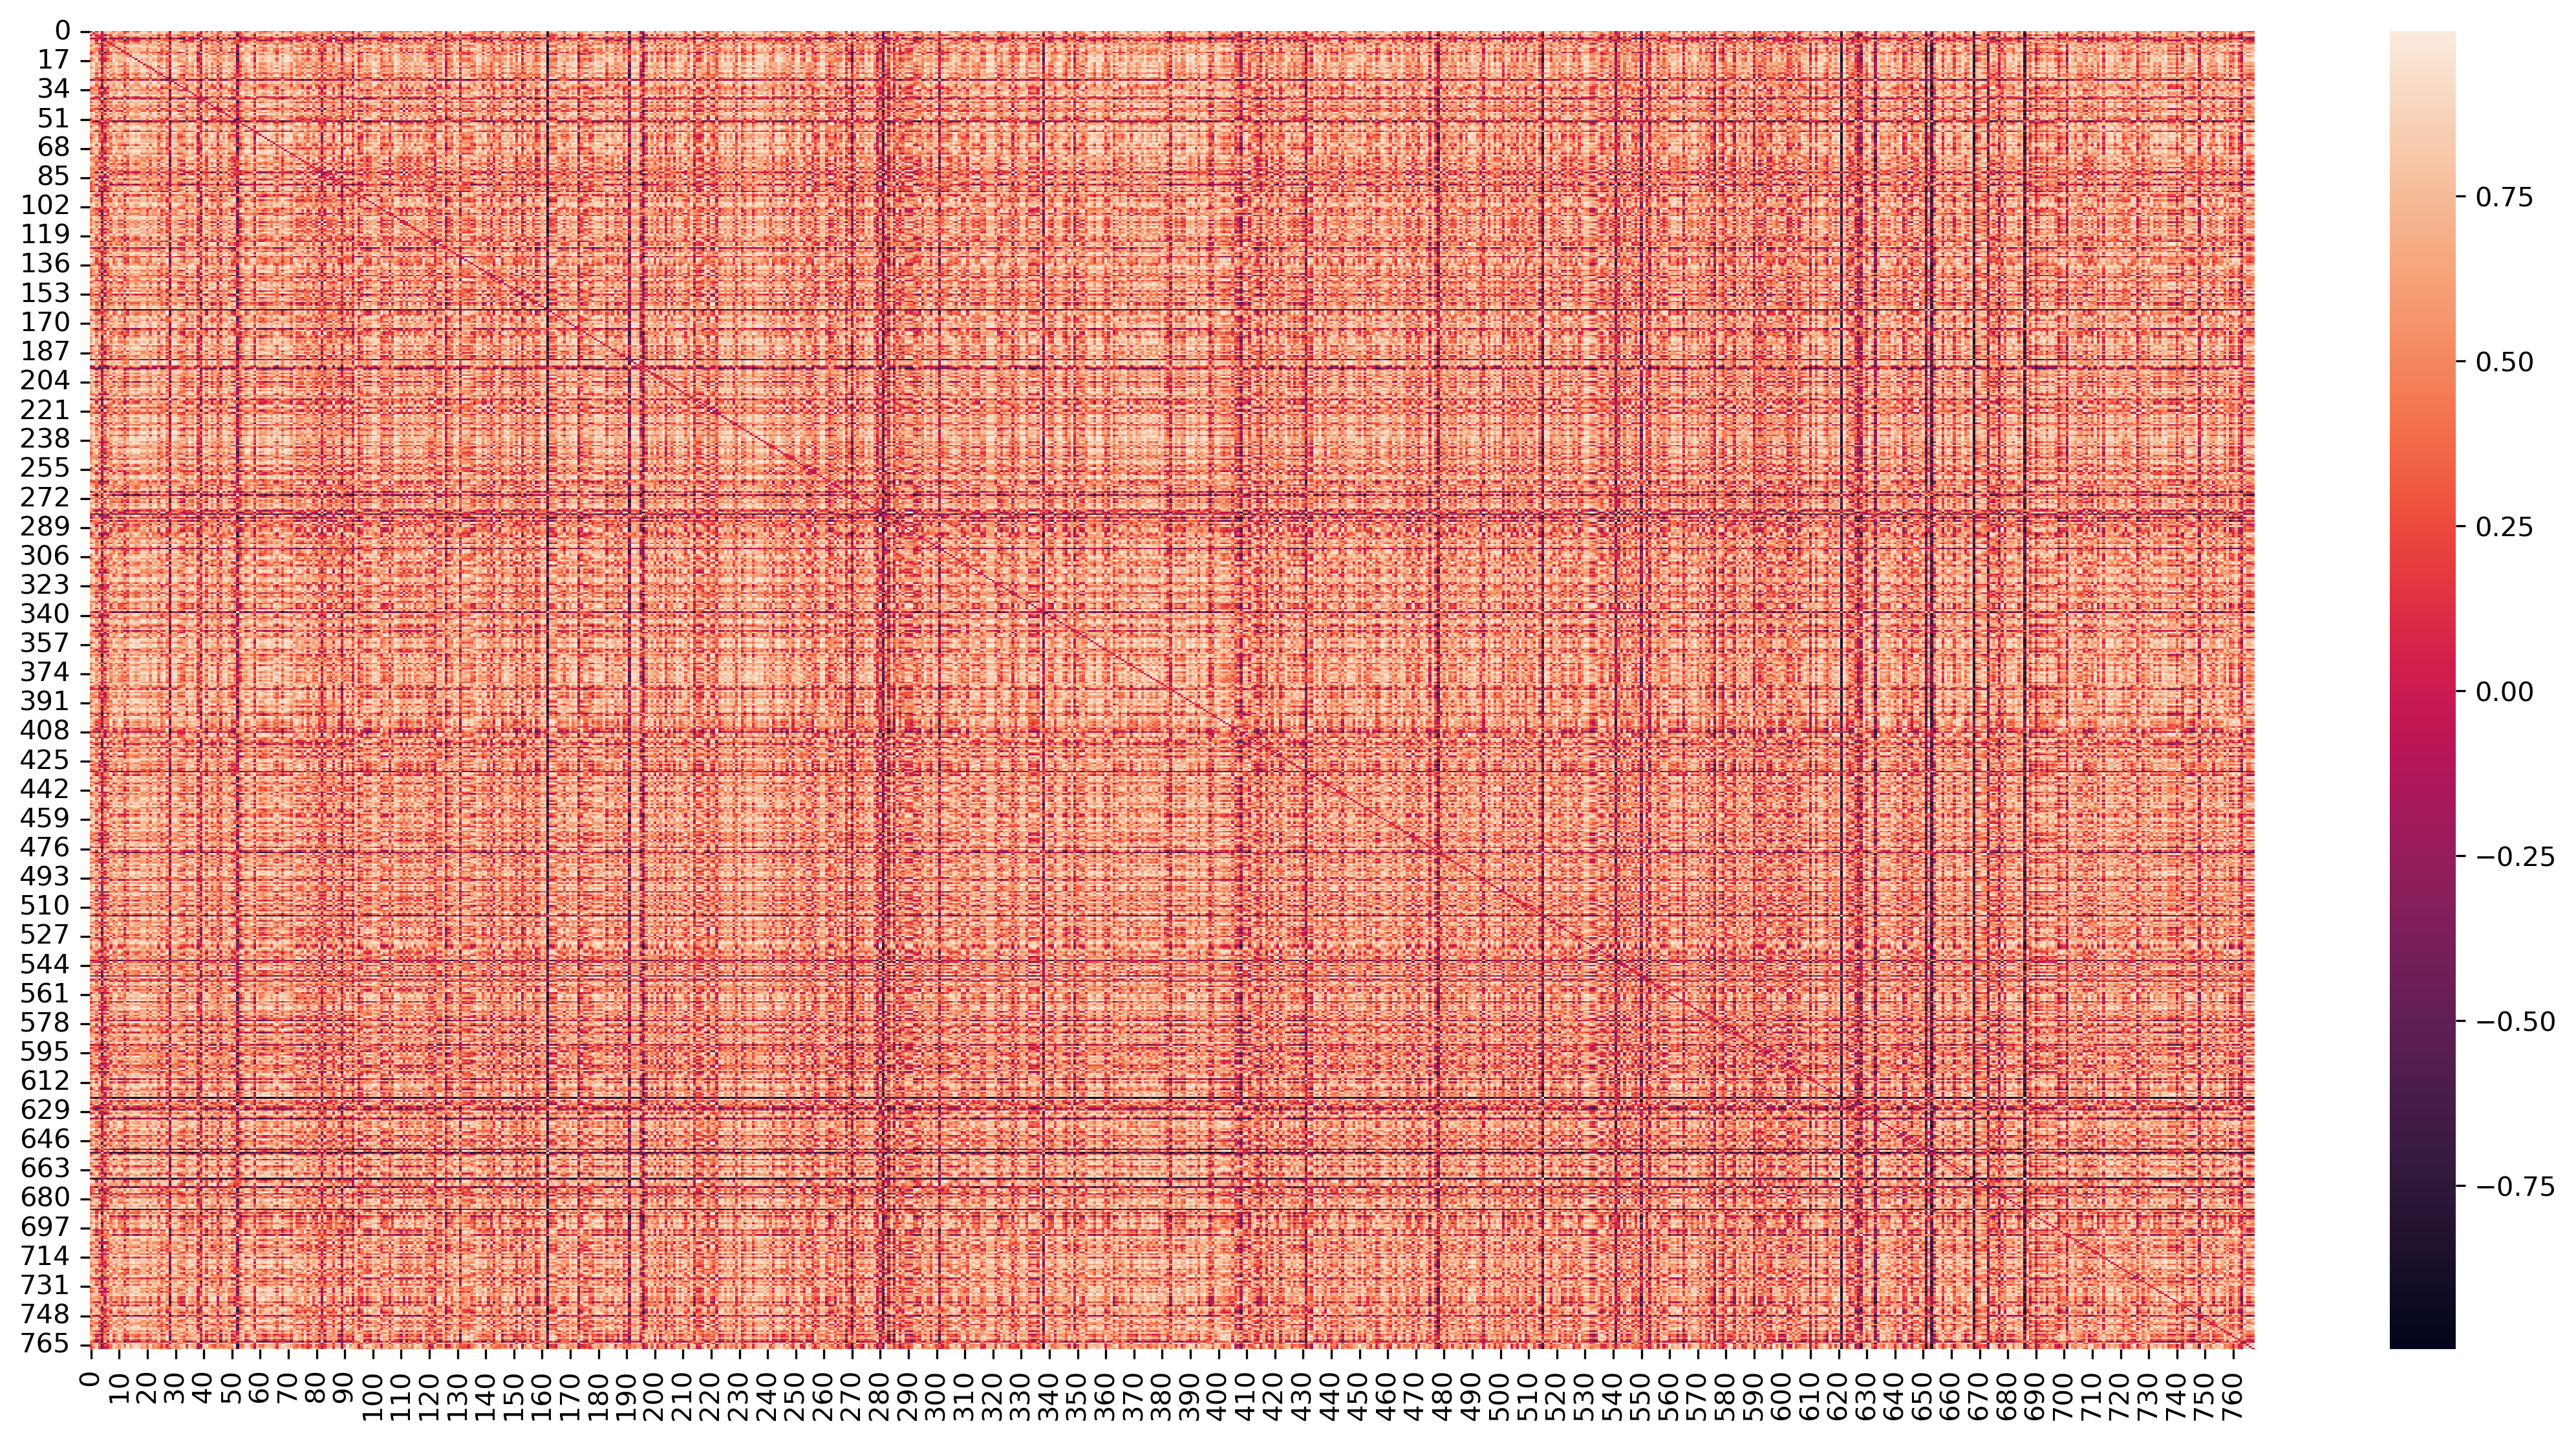

In [13]:
# build Doc2Vec embedding
docVectors = buildDocVectorMatrixByColumn(df, "ngram_lc_tagged_doc", vectorSize=4, minCount=1) # optimize the hyperparameters of this
docVecDF = pd.DataFrame(docVectors)

# Doc2Vec cosine similarity heatmap
cosSimMatrixDocs = buildAdjacencyMatrixByCosineSimilarity(docVectors)
figure(figsize=(18,9), dpi=300)
sns.heatmap(cosSimMatrixDocs)

### Uniform Manifold Approximation and Projection (UMAP) Dimensional Reduction
---

However, the data can still come out slightly noisy and overly complex. To overcome this, we use [UMAP](https://umap-learn.readthedocs.io/en/latest/), a dimensional reduction technique based on locally connected [Riemannian manifolds](https://en.wikipedia.org/wiki/Riemannian_manifold). Generally, UMAP preserves both the pairwise structure across data samples as well as local distances over global distances. It is also generalizable to any embedding technique and scales well with large datasets. For those keen, [the white paper](https://arxiv.org/pdf/1802.03426.pdf) details the math behind the algorithm and compares it with other dimensional reduction techniques like t-SNE.

Text(0.5, 1.0, 'UMAP projection of the Doc2Vec Embedding')

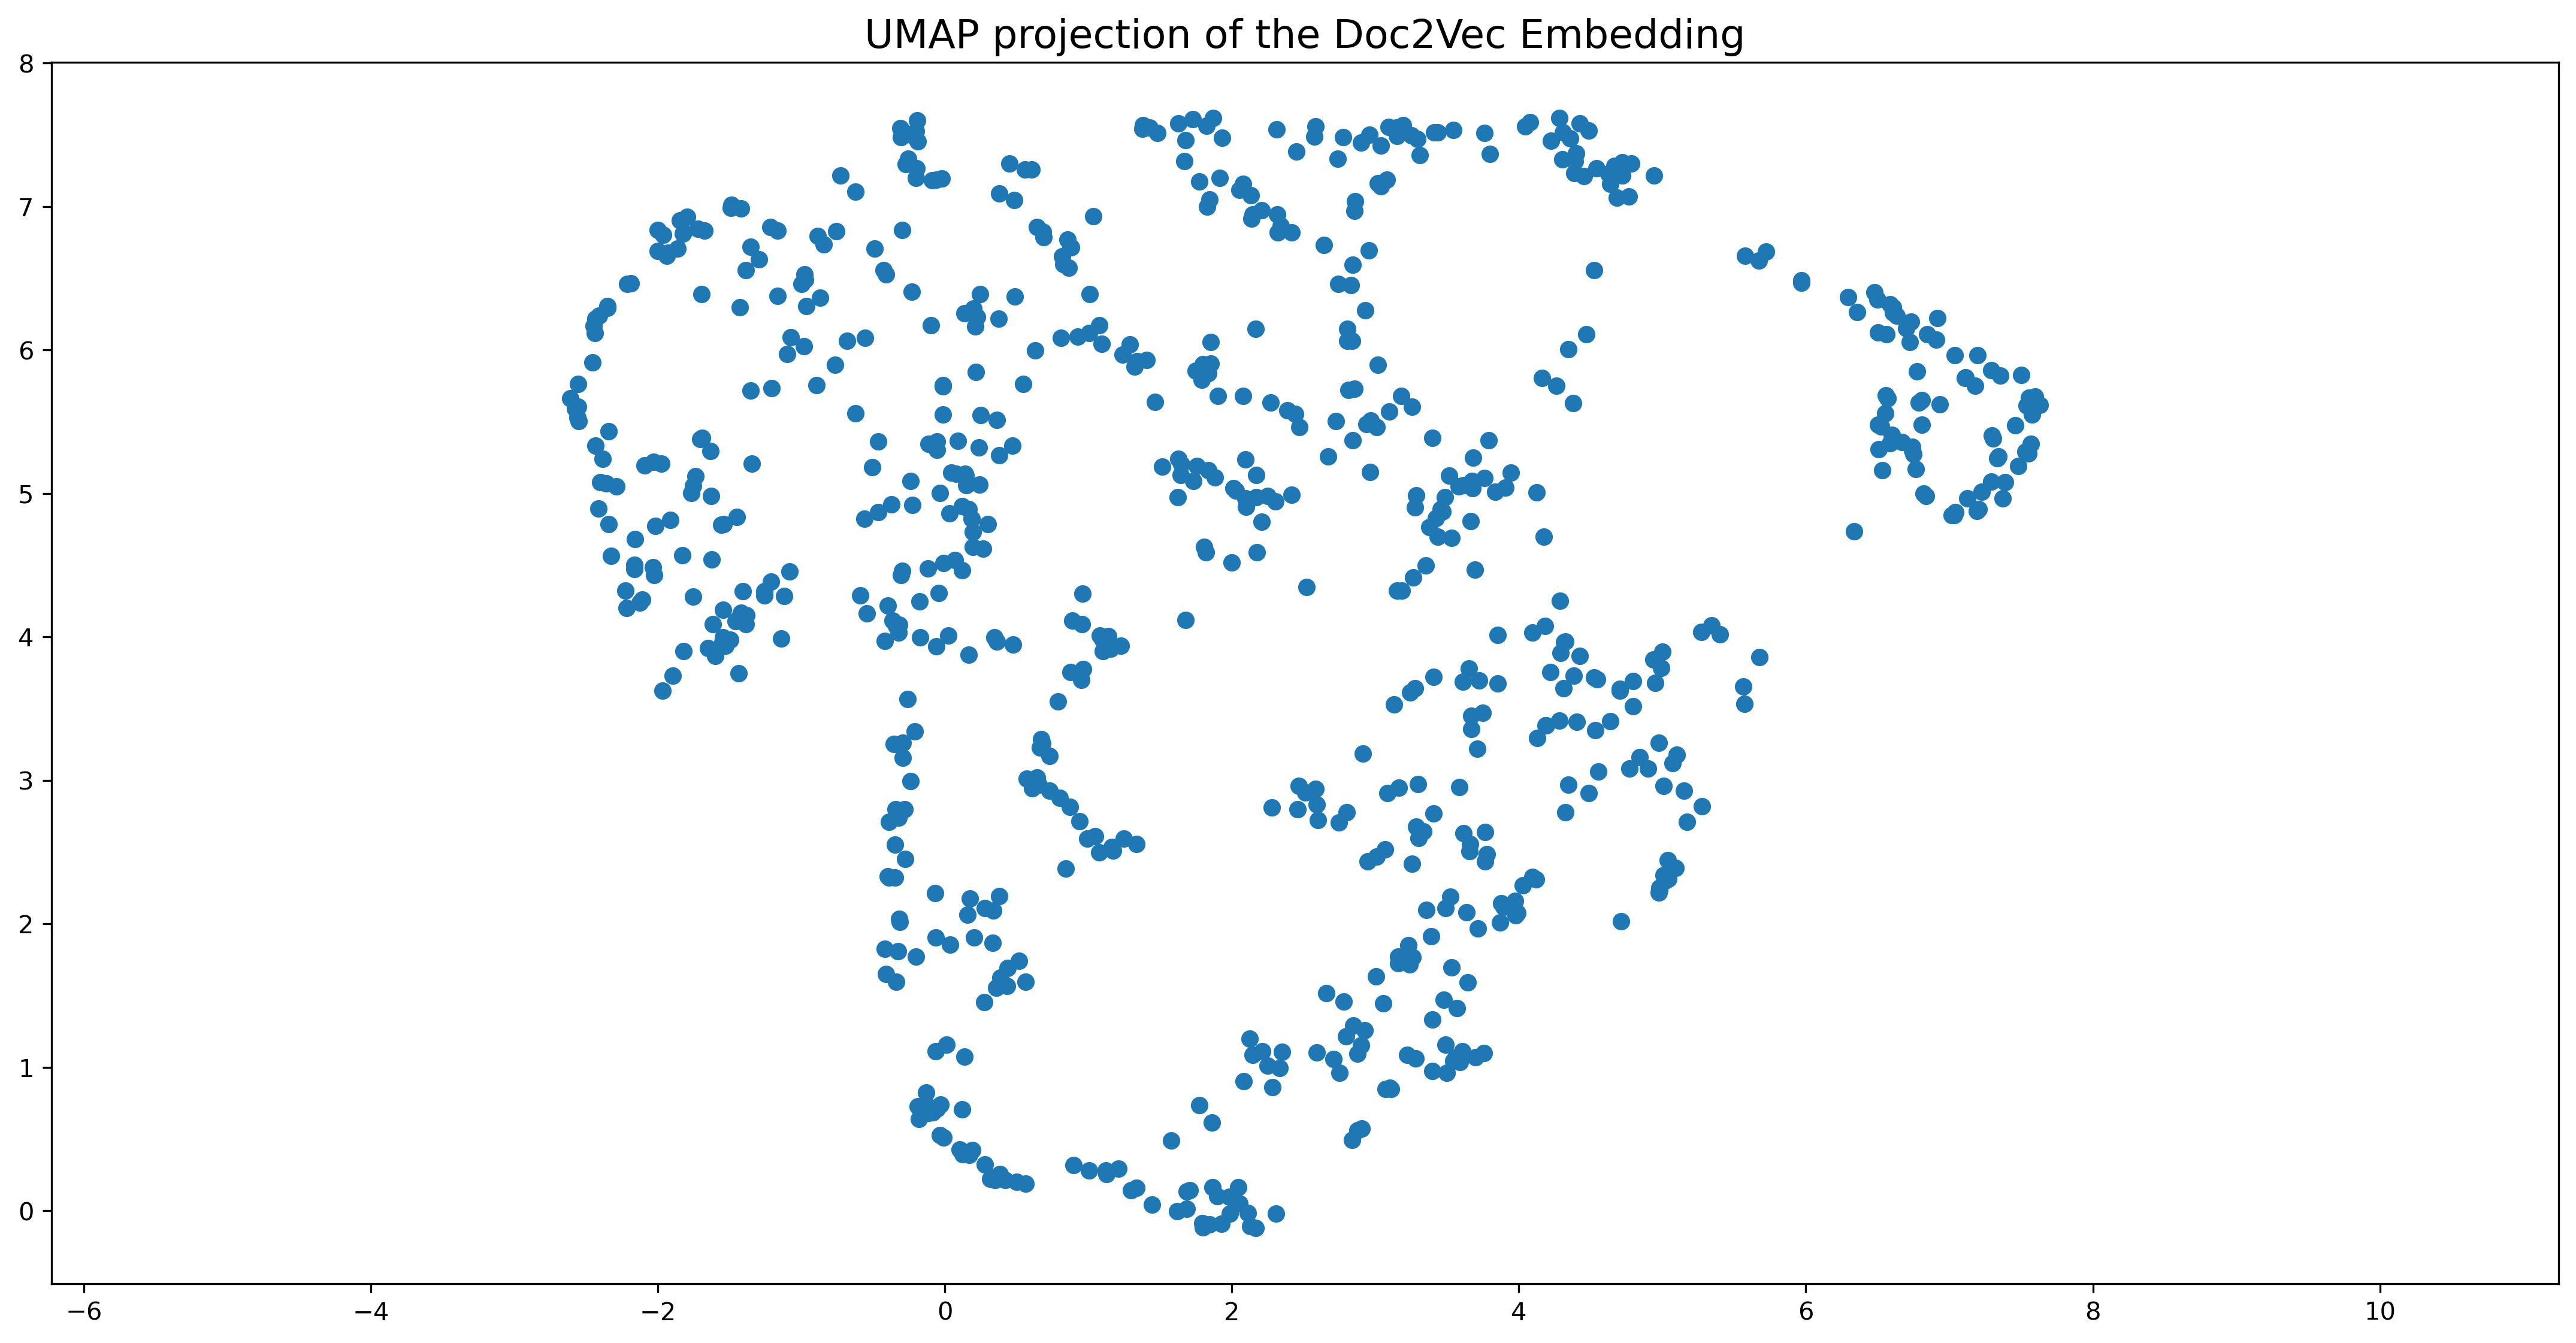

In [14]:
# UMAP
import umap

UMAP = umap.UMAP()
reducedEmbedding = UMAP.fit_transform(docVectors)
for n in range(reducedEmbedding.shape[1]):
    df["umap_embedding_" + str(n)] = reducedEmbedding[:,n] # add embeddings to dataframe
figure(figsize=(18,9), dpi=300)
plt.scatter(
    reducedEmbedding[:, 0],
    reducedEmbedding[:, 1],
    # figure out how to add colors from below (maybe after hdbscan)
    # c=[sns.color_palette()[x] for x in penguins.species_short.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})])
)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the Doc2Vec Embedding', fontsize=16)

### Hierarchical Density-Based Spatial Clustering of Applications with Noise (HDBSCAN)
---
[HDBSCAN](https://hdbscan.readthedocs.io/en/latest/how_hdbscan_works.html) further develops the underlying algorithm, DBSCAN, to create an unsupervised clustering application useable with almost any dataset. It trumps over algorithms like K-means clustering particularly in applications with noise or where the density of clusters can change. Here, the density of clusters generally refers to the distance between points of a particular cluster. Some clusters may be very similar and thus very dense, while others are broader and more spread apart, thus less dense.

Where HDBSCAN extends the underlying algorithm is in allowing hierarchies of clusters to take shape. The clustering algorithm will form clusters with varying values for $\epsilon$, the relative similarity between points necessary for them to form a cluster. Points can then be assigned to subtopics if they are densley packed together, as well as broader clusters of more general topics with lower similarity.

Estimated number of clusters: 5
Estimated number of noise points: 12
Silhouette Coefficient: -0.071


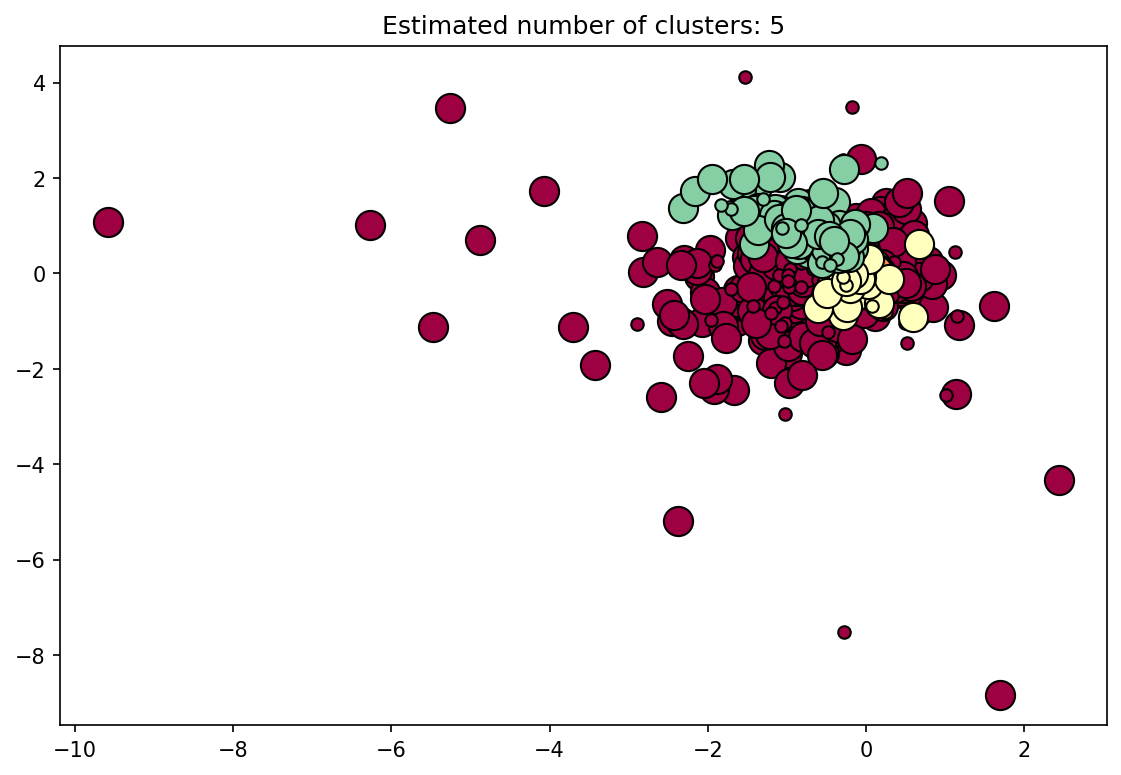

In [15]:
# DBSCAN, a single slice of HDBSCAN
from sklearn.cluster import DBSCAN
from sklearn import metrics

db = DBSCAN(eps=0.50, min_samples=10).fit(reducedEmbedding) # optimize hyperparameters, or just use HDBSCAN
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
unique_labels = set(labels)
n_clusters_ = len(labels) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % len(unique_labels))
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(docVectors, labels))

figure(figsize=(9,6), dpi=150)
# Black removed and is used for noise instead.

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        continue; # removes noise from plot
    class_member_mask = labels == k

    xy = docVectors[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = docVectors[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % len(unique_labels))
plt.show()

Estimated number of clusters: 3
Estimated number of noise points: 76
Silhouette Coefficient: -0.049


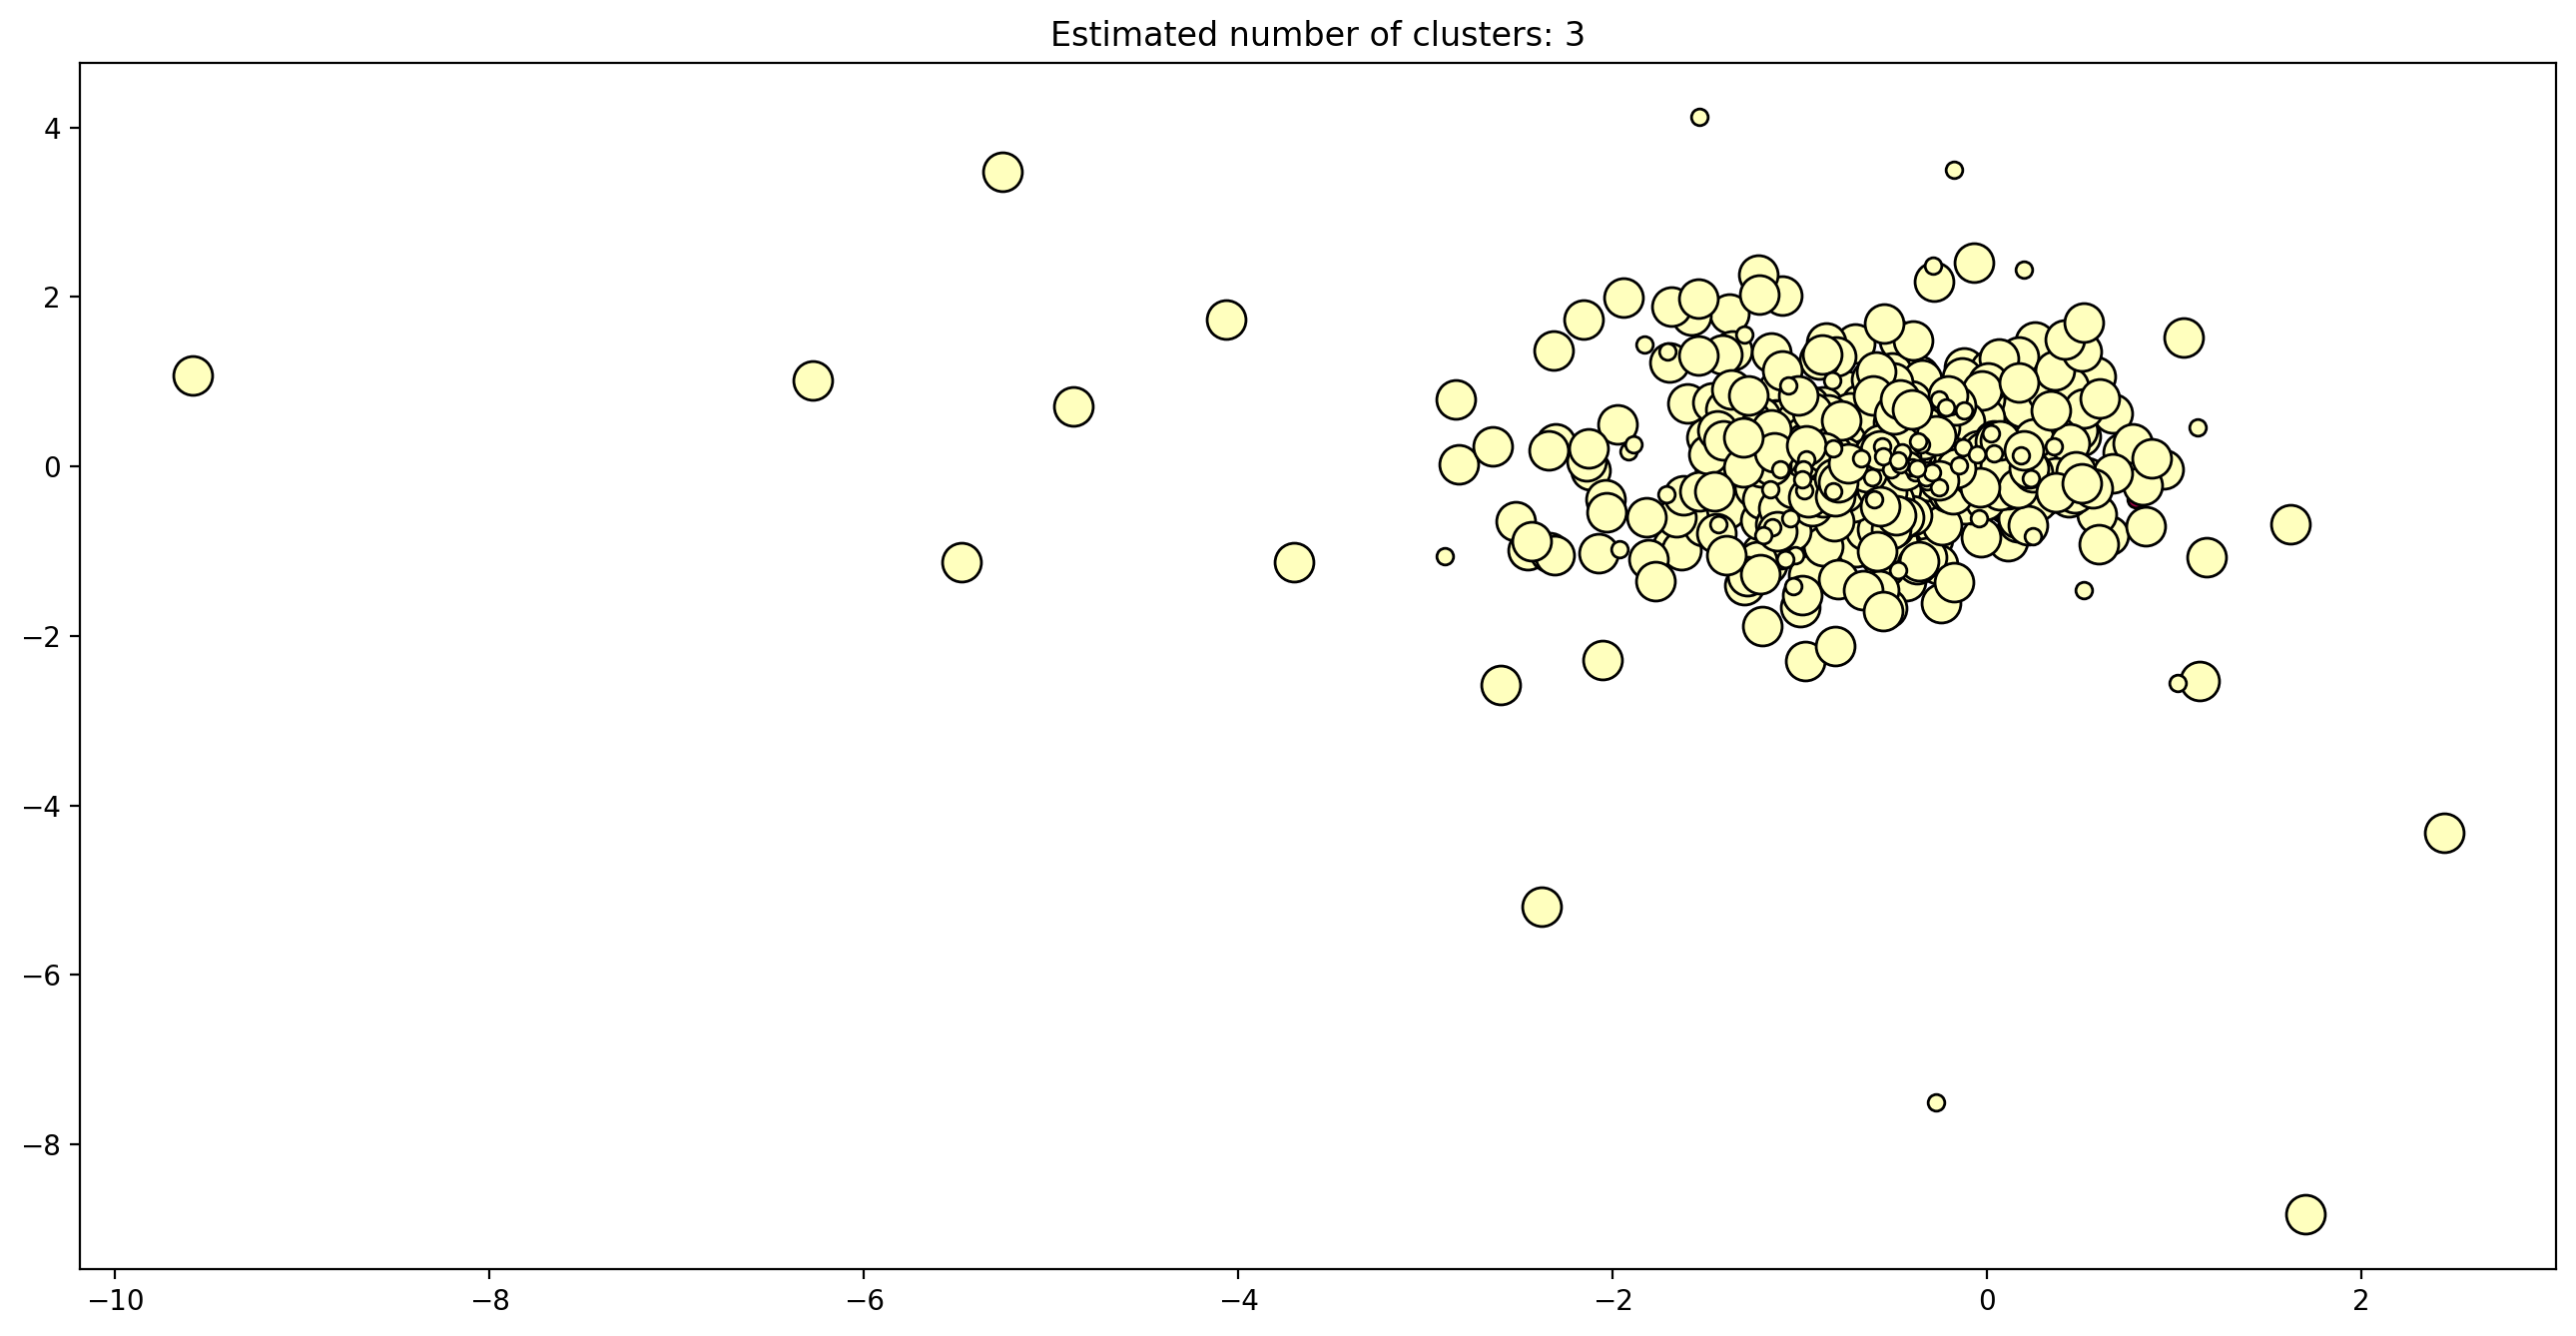

In [16]:
# HDBSCAN
import hdbscan
clusterer = hdbscan.HDBSCAN(min_cluster_size=50, gen_min_span_tree=True) # optimize hyperparameters
clusterer.fit(reducedEmbedding)
hdbscanLabels = clusterer.labels_
hdbscanProbabilities = clusterer.probabilities_
df["hdbscan_labels"] = hdbscanLabels
df["hdbscan_probabilities"] = hdbscanProbabilities

# Number of clusters in labels, ignoring noise if present.
unique_labels = set(hdbscanLabels)
n_clusters_ = len(hdbscanLabels) - (1 if -1 in hdbscanLabels else 0)
n_labels_ = len(unique_labels)
n_noise_ = list(hdbscanLabels).count(-1)

print("Estimated number of clusters: %d" % n_labels_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(docVectors, hdbscanLabels))


figure(figsize=(16,8), dpi=200)

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]
        continue; # removes noise from plot
    class_member_mask = hdbscanLabels == k

    xy = docVectors[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=14,
    )

    xy = docVectors[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=6,
    )

plt.title("Estimated number of clusters: %d" % n_labels_)
plt.show()

HDBSCAN defines a reachability metric to evaluate how similar clusters or points are to one another. To visualize the reachability between any two points, we can construct a [minimum spanning tree](https://en.wikipedia.org/wiki/Minimum_spanning_tree).

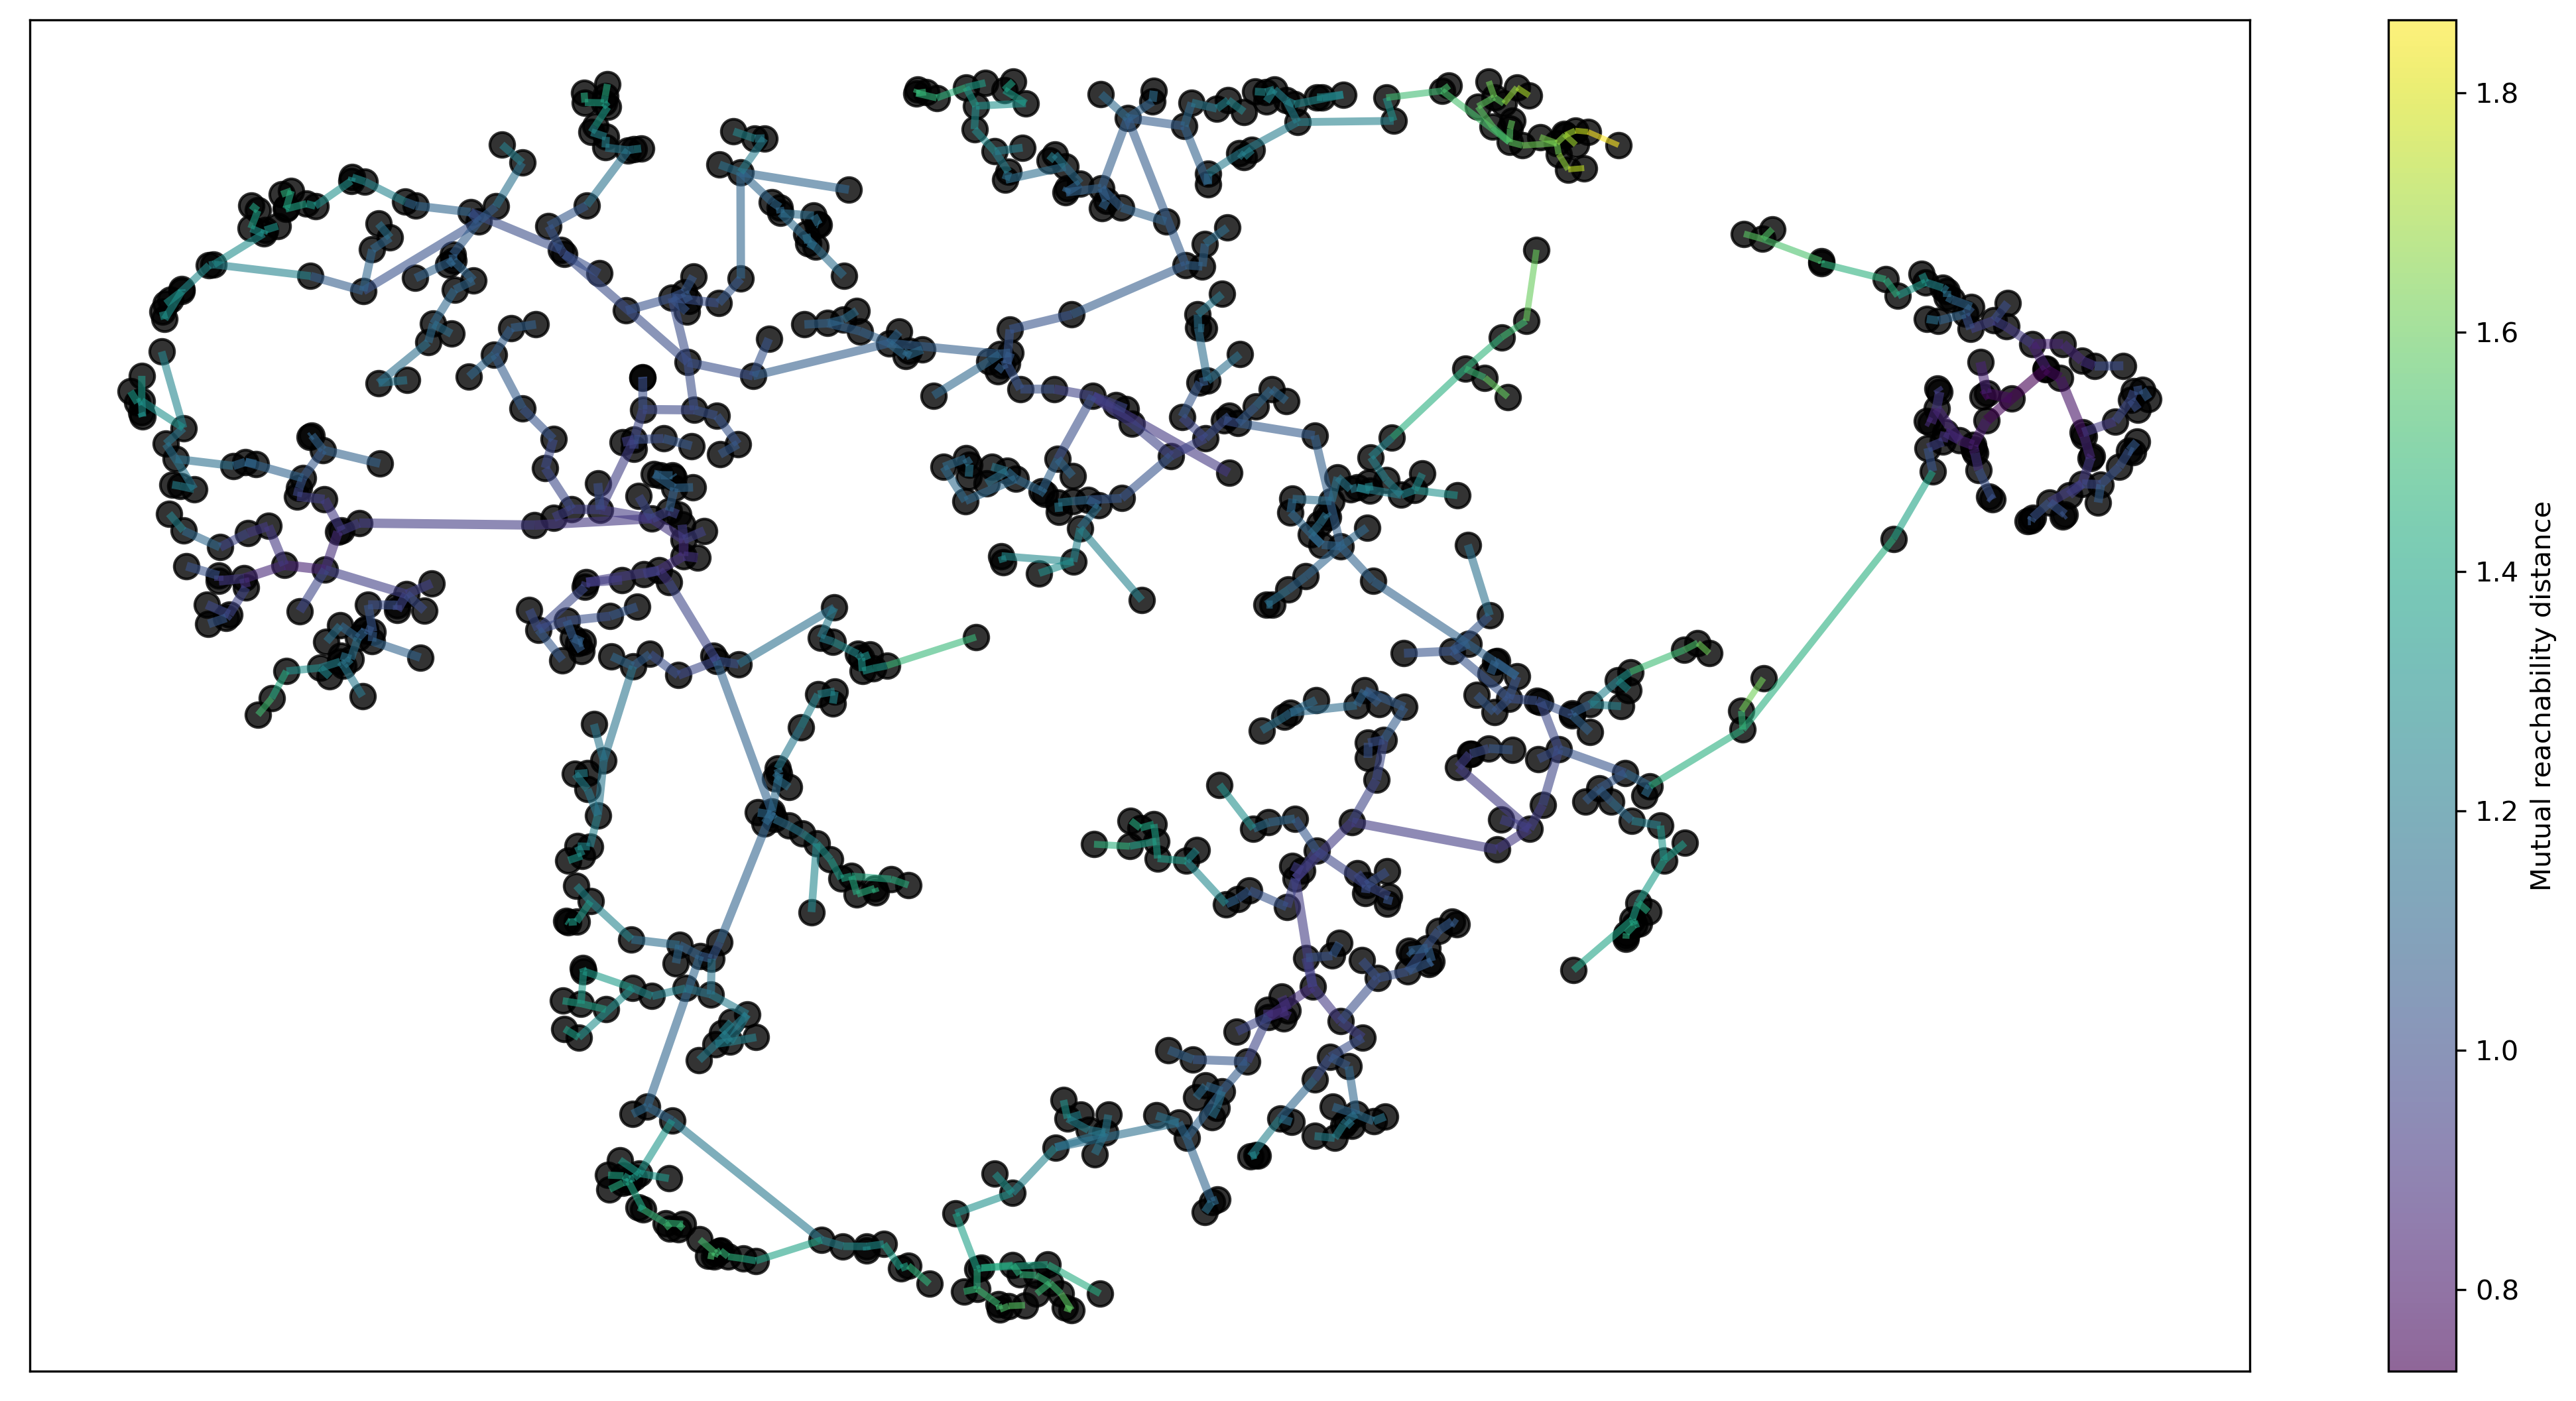

In [17]:
# visualize the minimum spanning tree
figure(figsize=(18,9), dpi=300)
axes = clusterer.minimum_spanning_tree_.plot(edge_cmap='viridis',
                                      edge_alpha=0.6,
                                      node_size=80,
                                      edge_linewidth=2)
plt.savefig(fname="test_minimum_spanning_tree.png")

From the minimum spanning tree, we can visualize the hierarchy of connected components via their reachability to one another. HDBSCAN is also capable of *condensing* the cluster tree to fewer, more defined clusters of points with more information in each cluster. The minimum cluster size is defined in the HDBSCAN object and, notably, is a hyperparameter that needs tuning. 

<AxesSubplot:ylabel='distance'>

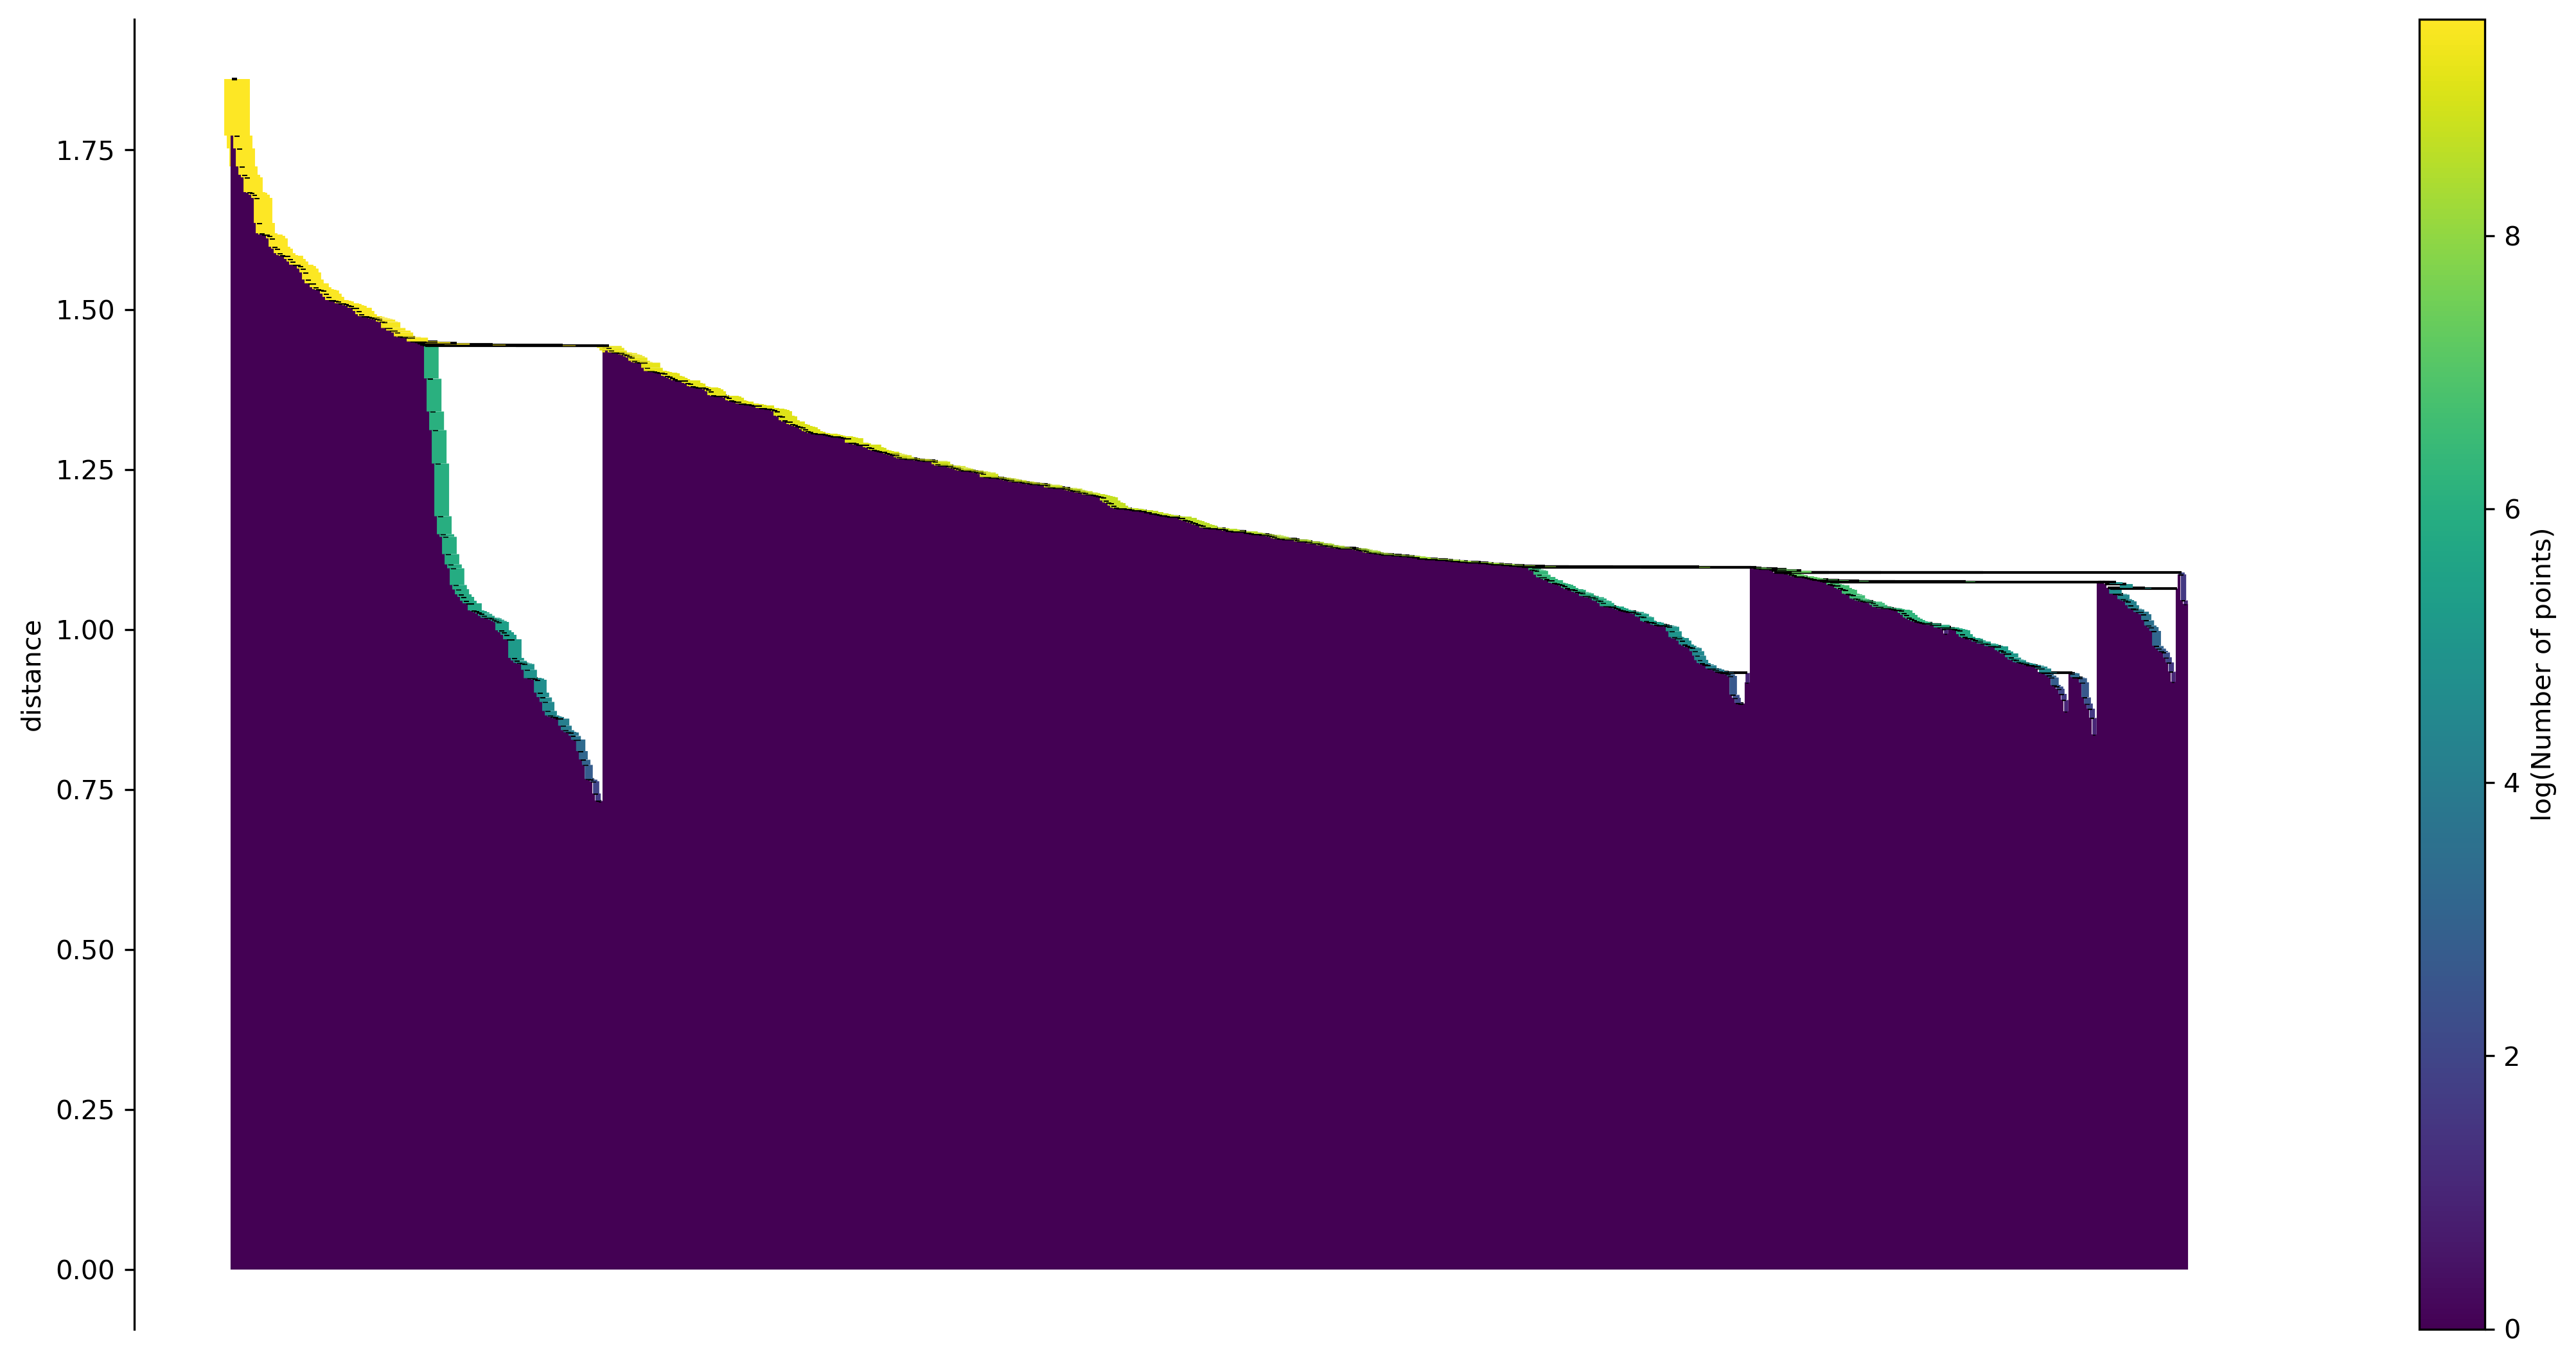

In [18]:
# visualize linkage tree
figure(figsize=(18,9), dpi=300)
clusterer.single_linkage_tree_.plot(cmap='viridis', colorbar=True)

### Class-based Term-Frequency Inverse-Document-Frequency (c-TF-IDF)
---
c-TF-IDF is an adaption of TF-IDF. Rather than looking at the whole corpus of documents to pull out the frequency data, it instead separates the data into classes (defined by the clusters extracted above) and concatenates all documents from a class into a single string. The frequency of words is then calculated for each class, and can be used to generate features of the classes or to condense classes based on how similar their term frequencies are.

In [19]:
# group data by topic
dfTopic = df.copy(deep=True)
dfTopic = dfTopic.reset_index()
dfTopic = dfTopic.groupby("hdbscan_labels").agg({"ngram_lc_tagged_doc": " ".join})
dfTopic.head()

ngram_lc_tagged_doc
hdbscan_labels                                                   
-1              hennig86 program. routine hennig86. routine he...
 0              antediluvian. hennig86 software. use hennig86....
 1              antediluvian. antediluvian humanity. antediluv...

In [20]:
# c-TF-IDF from: https://github.com/MaartenGr/BERTopic/blob/master/bertopic/_ctfidf.py
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import normalize
from sklearn.utils import check_array
import numpy as np
import scipy.sparse as sp


class ClassTFIDF(TfidfTransformer):
    """
    A Class-based TF-IDF procedure using scikit-learns TfidfTransformer as a base.
    ![](../img/ctfidf.png)
    C-TF-IDF can best be explained as a TF-IDF formula adopted for multiple classes
    by joining all documents per class. Thus, each class is converted to a single document
    instead of set of documents. Then, the frequency of words **t** are extracted for
    each class **i** and divided by the total number of words **w**.
    Next, the total, unjoined, number of documents across all classes **m** is divided by the total
    sum of word **i** across all classes.
    """
    def __init__(self):
        super(ClassTFIDF, self).__init__()

    def fit(self, X: sp.csr_matrix, multiplier: np.ndarray = None):
        """Learn the idf vector (global term weights).
        Arguments:
            X: A matrix of term/token counts.
            multiplier: A multiplier for increasing/decreasing certain IDF scores
        """
        X = check_array(X, accept_sparse=('csr', 'csc'))
        if not sp.issparse(X):
            X = sp.csr_matrix(X)
        dtype = np.float64

        if self.use_idf:
            _, n_features = X.shape

            # Calculate the frequency of words across all classes
            df = np.squeeze(np.asarray(X.sum(axis=0)))

            # Calculate the average number of samples as regularization
            avg_nr_samples = int(X.sum(axis=1).mean())

            # Divide the average number of samples by the word frequency
            # +1 is added to force values to be positive
            idf = np.log((avg_nr_samples / df)+1)

            # Multiplier to increase/decrease certain idf scores
            if multiplier is not None:
                idf = idf * multiplier

            self._idf_diag = sp.diags(idf, offsets=0,
                                      shape=(n_features, n_features),
                                      format='csr',
                                      dtype=dtype)

        return self

    def transform(self, X: sp.csr_matrix):
        """Transform a count-based matrix to c-TF-IDF
        Arguments:
            X (sparse matrix): A matrix of term/token counts.
        Returns:
            X (sparse matrix): A c-TF-IDF matrix
        """
        if self.use_idf:
            X = normalize(X, axis=1, norm='l1', copy=False)
            X = X * self._idf_diag

        return X

In [21]:
# pull out top 10 words from each cluster
count_vectorizer = CountVectorizer().fit(dfTopic["ngram_lc_tagged_doc"])
count = count_vectorizer.transform(dfTopic["ngram_lc_tagged_doc"])
words = count_vectorizer.get_feature_names_out()

ctfidf = ClassTFIDF().fit(count)
ctfidfData = ctfidf.transform(count).toarray()

words_per_class = {}
for index in dfTopic.index:
    words_per_class[index] = [words[index] for index in ctfidfData[index].argsort()[-10:]]
words_per_class

{-1: ['animal',
  'period',
  'king',
  'use',
  'hero',
  'world',
  'patriarch',
  'seventh',
  'hennig86',
  'antediluvian'],
 0: ['city',
  'remain',
  'analysis',
  'use',
  'king',
  'tradition',
  'version',
  'program',
  'antediluvian',
  'hennig86'],
 1: ['animal',
  'life',
  'software',
  'lead',
  'use',
  'patriarch',
  'version',
  'seventh',
  'hennig86',
  'antediluvian']}

In [ ]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count

In [ ]:
docs_per_topic = df.groupby(['hdbscan_labels'], as_index = False).agg({'ngram_lc_tagged_doc': ' '.join})
m = len(df)
tf_idf = c_tf_idf(docs_per_topic["ngram_lc_tagged_doc"].values, m)

In [ ]:
# topic reduction
from sklearn.metrics.pairwise import cosine_similarity

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

for i in range(10):
    # Calculate cosine similarity
    similarities = cosine_similarity(tf_idf.T)
    np.fill_diagonal(similarities, 0)

    # Extract label to merge into and from where
    topic_sizes = pd.DataFrame(df.groupby(['hdbscan_labels']).count().sort_values("ngram_lc_tagged_doc", ascending=False)["ngram_lc_tagged_doc"])
    topic_to_merge = topic_sizes.iloc[-1].index
    topic_to_merge_into = np.argmax(similarities[topic_to_merge + 1]) - 1

    # Adjust topics
    df.loc[df.index == topic_to_merge, "hdbscan_labels"] = topic_to_merge_into
    old_topics = df.sort_values("hdbscan_labels").index.unique()
    map_topics = {old_topic: index - 1 for index, old_topic in enumerate(old_topics)}
    df.index = df.index.map(map_topics)
    docs_per_topic = df.groupby(['hdbscan_labels'], as_index = False).agg({'ngram_lc_tagged_doc': ' '.join})

    # Calculate new topic words
    m = len(df.index)
    tf_idf, count = c_tf_idf(docs_per_topic["ngram_lc_tagged_doc"].values, m)
    top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)

topic_sizes = extract_topic_sizes(df); topic_sizes.head(10)

### Maximize Marginal Relevance (MMR)

In [ ]:
# https://medium.com/tech-that-works/maximal-marginal-relevance-to-rerank-results-in-unsupervised-keyphrase-extraction-22d95015c7c5
from sklearn.metrics.pairwise import cosine_similarity

def maximal_marginal_relevance(sentence_vector, phrases, embedding_matrix, lambda_constant=0.5, threshold_terms=10):
    """
    Return ranked phrases using MMR. Cosine similarity is used as similarity measure.
    :param sentence_vector: Query vector
    :param phrases: list of candidate phrases
    :param embedding_matrix: matrix having index as phrases and values as vector
    :param lambda_constant: 0.5 to balance diversity and accuracy. if lambda_constant is high, then higher accuracy. If lambda_constant is low then high diversity.
    :param threshold_terms: number of terms to include in result set
    :return: Ranked phrases with score
    """
    # todo: Use cosine similarity matrix for lookup among phrases instead of making call everytime.
    s = []
    r = sorted(phrases, key=lambda x: x[1], reverse=True)
    r = [i[0] for i in r]
    while len(r) > 0:
        score = 0
        phrase_to_add = ''
        for i in r:
            first_part = cosine_similarity([sentence_vector], [embedding_matrix.loc[i]])[0][0]
            second_part = 0
            for j in s:
                cos_sim = cosine_similarity([embedding_matrix.loc[i]], [embedding_matrix.loc[j[0]]])[0][0]
                if cos_sim > second_part:
                    second_part = cos_sim
            equation_score = lambda_constant*(first_part)-(1-lambda_constant) * second_part
            if equation_score > score:
                score = equation_score
                phrase_to_add = i
        if phrase_to_add == '':
            phrase_to_add = i
        r.remove(phrase_to_add)
        s.append((phrase_to_add, score))
    return (s, s[:threshold_terms])[threshold_terms > len(s)]

In [ ]:
# https://maartengr.github.io/KeyBERT/api/mmr.html#keybert._mmr.mmr
import numpy as np
from operator import itemgetter
from typing import List, Tuple
from sklearn.metrics.pairwise import cosine_similarity

def mmr(
    doc_embedding: np.ndarray,
    word_embeddings: np.ndarray,
    words: List[str],
    top_n: int = 5,
    diversity: float = 0.8,
) -> List[Tuple[str, float]]:
    """Calculate Maximal Marginal Relevance (MMR)
    between candidate keywords and the document.


    MMR considers the similarity of keywords/keyphrases with the
    document, along with the similarity of already selected
    keywords and keyphrases. This results in a selection of keywords
    that maximize their within diversity with respect to the document.

    Arguments:
        doc_embedding: The document embeddings
        word_embeddings: The embeddings of the selected candidate keywords/phrases
        words: The selected candidate keywords/keyphrases
        top_n: The number of keywords/keyhprases to return
        diversity: How diverse the select keywords/keyphrases are.
                   Values between 0 and 1 with 0 being not diverse at all
                   and 1 being most diverse.

    Returns:
         List[Tuple[str, float]]: The selected keywords/keyphrases with their distances

    """

    # Extract similarity within words, and between words and the document
    word_doc_similarity = cosine_similarity(word_embeddings, doc_embedding)
    word_similarity = cosine_similarity(word_embeddings)

    # Initialize candidates and already choose best keyword/keyphras
    keywords_idx = [np.argmax(word_doc_similarity)]
    candidates_idx = [i for i in range(len(words)) if i != keywords_idx[0]]

    for _ in range(min(top_n - 1, len(words) - 1)):
        # Extract similarities within candidates and
        # between candidates and selected keywords/phrases
        candidate_similarities = word_doc_similarity[candidates_idx, :]
        target_similarities = np.max(
            word_similarity[candidates_idx][:, keywords_idx], axis=1
        )

        # Calculate MMR
        mmr = (
            1 - diversity
        ) * candidate_similarities - diversity * target_similarities.reshape(-1, 1)
        mmr_idx = candidates_idx[np.argmax(mmr)]

        # Update keywords & candidates
        keywords_idx.append(mmr_idx)
        candidates_idx.remove(mmr_idx)

    # Extract and sort keywords in descending similarity
    keywords = [
        (words[idx], round(float(word_doc_similarity.reshape(1, -1)[0][idx]), 4))
        for idx in keywords_idx
    ]
    keywords = sorted(keywords, key=itemgetter(1), reverse=True)
    return keywords


In [ ]:
numTopics = len(dfTopic.index)-1 # skip topic -1: its designated for documents with no topic
keywordDict = {}
w2v_vectors
docVectors

for n in range(numTopics):
    tfidfArray = np.array(list(tfidfDict[n].values()))
    wordArray = np.array(list(tfidfDict[n].keys()))
    keywords = mmr(docVectors, tfidfArray, wordArray)
    keywordDict[n] = keywords

### Building Networks

In [22]:
print("Building Networkx Graphs...")
t0 = time()
T = 0.8 # hyperparameter
cosSimMatrix = cosSimMatrixDocs # Doc2Vec cosine similarity matrix from heatmap (above)
cosSimMatrix[cosSimMatrix < T] = 0
cosSimMatrix = cosSimMatrix * 5 # multiply by scalar (another hyperparameter)
G = nx.from_numpy_array(cosSimMatrix)
print("Done in %0.3fs.\n" % (time() - t0))

Building Networkx Graphs...
Done in 0.202s.



In [28]:
G = clusterer.minimum_spanning_tree_.to_networkx()

In [23]:
print("Adding Node Metadata...")
t0 = time()
numCommunities = 0
numNodes = len(df)
nodes = list(range(numNodes))
scalingFactor = 1000. # scales the node size for visibility
adjMatrix = cosSimMatrixDocs

for n in nodes:
    # 'title': hash (i.e. dataframe index)
    # 'group': partition
    # 'value': topic (empty for now)
    # 'size': normalized YAKE score
    G.nodes[n]["title"] = df.index[n] # this (clearly) doesn't work for matrices based on words (e.g. cooccurence)
    G.nodes[n]["group"] = hdbscanLabels[n] # from HDBSCAN
    G.nodes[n]["size"] = df["term_freq"][n] * scalingFactor
print("Done in %0.3fs.\n" % (time() - t0))

Adding Node Metadata...
Done in 0.006s.



##### Network/Topic Visualization

AttributeError: module 'scipy.sparse' has no attribute 'coo_array'

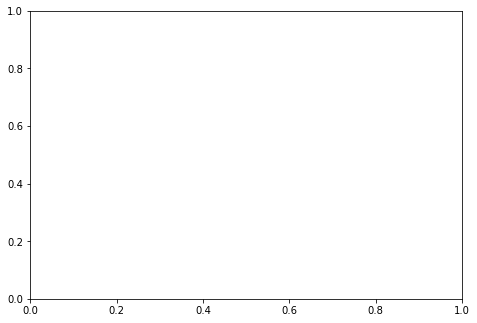

In [29]:
nx.draw(G)
plt.show()

PyVis

In [ ]:
# input the network you would like to visualize below as a NetworkX object in the first parameter
# recommended to only run this after validating the network with the above graphs and statistics
# if it is taking a while to run/load the image, set _physics=False
visualizeNetworkHTML(G, _filename="test vector cosine.html", _width="3840px", _height="2160px", _physics=False)

Key nodes

In [ ]:
# bridge node
df.loc["3bad1c0f3b983ab81ddff3f5e90e687310269d16"]